# Prediksi Fenotipe Keturunan Berdasarkan Genotipe Induk

Notebook ini mengimplementasikan berbagai algoritma machine learning untuk memprediksi fenotipe keturunan (offspring) berdasarkan informasi genotipe induk untuk organisme flora dan fauna. Kami menggunakan dataset `combined_genetics_dataset.csv` yang berisi:

- **OrganismType**: Flora atau Fauna
- **ParentGenotype**: Informasi genetik induk
- **ParentGamete**: Gamet yang dihasilkan induk
- **OffspringGenotype**: Informasi genetik keturunan (target prediksi)
- **OffspringPhenotype**: Sifat fisik yang muncul pada keturunan (target prediksi)

## Model yang Digunakan:
1. **Decision Tree** - Aturan keputusan yang jelas dan mudah diinterpretasi
2. **Naive Bayes** - Model probabilistik berdasarkan teorema Bayes
3. **Logistic Regression** - Model linear untuk klasifikasi

In [16]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn ipywidgets

In [17]:
# Import semua libraries yang diperlukan dalam notebook ini
# Disusun berdasarkan kategori untuk kemudahan pemahaman

# ===== LIBRARIES DASAR =====
# Libraries untuk manipulasi data dan operasi numerik
import pandas as pd
import numpy as np

# ===== LIBRARIES VISUALISASI =====
# Libraries untuk visualisasi data dan hasil model
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle  # Untuk membuat siklus warna dalam plot

# ===== LIBRARIES PREPROCESSING =====
# Libraries untuk preprocessing data
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer

# ===== LIBRARIES MODEL MACHINE LEARNING =====
# Decision Tree
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Naive Bayes
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Tambahan model yang mungkin digunakan untuk perbandingan
from sklearn.neighbors import KNeighborsClassifier

# ===== LIBRARIES EVALUASI MODEL =====
# Libraries untuk mengevaluasi performa model
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    balanced_accuracy_score, f1_score, roc_auc_score,
    roc_curve, auc  # Untuk ROC curve visualization
)

# ===== LIBRARIES UNTUK HANDLING DATA TIDAK SEIMBANG =====
from imblearn.over_sampling import SMOTE

# ===== LIBRARIES UNTUK VISUALISASI INTERAKTIF =====
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# ===== PENGATURAN UMUM =====
# Suppress warnings untuk membersihkan output
import warnings
warnings.filterwarnings('ignore')

# Set style untuk plotting
plt.style.use('default')
sns.set_palette("viridis")

print("Libraries berhasil diimport!")

Libraries berhasil diimport!


## 1. Data Loading dan Eksplorasi

In [18]:
# =====================================================================
# DATA LOADING DAN EKPLORASI
# =====================================================================

# Dataset ini berisi informasi genetik organisme flora dan fauna
# Kita akan menganalisis informasi genotipe induk dan fenotipe keturunan
df = pd.read_csv('combined_genetics_dataset.csv')

# Tampilkan dimensi dataset
print(f"Jumlah baris dan kolom: {df.shape}")

# Tampilkan sampel data
print("\nSampel 5 baris pertama:")
print(df.head(5))

# Periksa nilai null dalam dataset
print("\nPengecekan nilai yang hilang (null):")
print(df.isnull().sum())

# Statistik deskriptif dasar
print("\nStatistik deskriptif:")
print(df.describe(include='all').T)  # Transpose untuk tampilan yang lebih baik

# Distribusi target (penting untuk memahami keseimbangan kelas)
print("\nDistribusi OffspringPhenotype (Target):")
target_distribution = df['OffspringPhenotype'].value_counts()
print(target_distribution)
print(f"\nPersentase distribusi target:")
for phenotype, count in target_distribution.items():
    print(f"- {phenotype}: {count/len(df):.2%}")

# Distribusi tipe organisme
print("\nDistribusi OrganismType:")
organism_dist = df['OrganismType'].value_counts()
print(organism_dist)
print(f"\nPersentase distribusi organisme:")
for org_type, count in organism_dist.items():
    print(f"- {org_type}: {count/len(df):.2%}")

# Visualisasi distribusi target (penting untuk memahami keseimbangan kelas)
# plt.figure(figsize=(10, 6))
# sns.countplot(data=df, y='OffspringPhenotype', order=df['OffspringPhenotype'].value_counts().index, palette='viridis')
# plt.title('Distribusi Fenotipe Keturunan (Target)')
# plt.xlabel('Jumlah Sampel')
# plt.ylabel('Fenotipe Keturunan')
# plt.tight_layout()
# plt.show()

# Visualisasi distribusi tipe organisme
# plt.figure(figsize=(6, 4))
# sns.countplot(data=df, x='OrganismType', palette='viridis')
# plt.title('Distribusi Tipe Organisme')
# plt.xlabel('Tipe Organisme')
# plt.ylabel('Jumlah Sampel')
# plt.tight_layout()
# plt.show()

Jumlah baris dan kolom: (50000, 7)

Sampel 5 baris pertama:
  OrganismType Parent1Genotype Parent1Gamete Parent2Genotype Parent2Gamete  \
0        Flora            AABB            ab              aa             a   
1        Flora            aaBB            aB            aaBB            aB   
2        Fauna            EEtt            Et            EeTT            ET   
3        Fauna            EeTt            et            EETt            ET   
4        Flora              AA             A            AAbb            Ab   

  OffspringGenotype OffspringPhenotype  
0               aab     White Wrinkled  
1              aaBB        White Round  
2              EETt    TailShort,Brown  
3              EeTt    TailShort,Brown  
4               AAb    Purple Wrinkled  

Pengecekan nilai yang hilang (null):
OrganismType          0
Parent1Genotype       0
Parent1Gamete         0
Parent2Genotype       0
Parent2Gamete         0
OffspringGenotype     0
OffspringPhenotype    0
dtype: int64

Stati

## 2. Feature Engineering dan Preprocessing

In [19]:
# Feature Engineering dan Preprocessing Data
def preprocess_data(df):
    """
    Melakukan preprocessing data untuk model machine learning:
    1. Ekstraksi fitur dari genotipe induk untuk mendapatkan informasi tentang alel
    2. Encoding kategorikal untuk fitur dan target menggunakan LabelEncoder
    3. Transformasi data untuk format yang sesuai dengan model ML

    Args:
        df: DataFrame asli yang berisi data genetik

    Returns:
        df_processed: DataFrame setelah preprocessing
        le_dict: Dictionary berisi encoder untuk setiap kolom kategorikal
    """
    # Buat salinan dataframe untuk menghindari modifikasi data asli
    df_processed = df.copy()

    # ===== EKSTRAKSI FITUR GENETIK =====
    # Tahap ini penting untuk mengubah data genetik menjadi format yang dapat diproses
    # oleh algoritma machine learning. Kita mengekstrak informasi tentang keberadaan
    # alel-alel tertentu dalam genotipe induk.

    # --- Ekstrak informasi genetik dari induk pertama (flora) ---
    # Mendeteksi keberadaan alel A pada genotipe induk 1 untuk organisme Flora
    # Nilai True jika alel A ada dalam genotipe, False jika tidak
    df_processed['P1_Has_A'] = df_processed.apply(
        lambda row: 'A' in row['Parent1Genotype'] if row['OrganismType'] == 'Flora' else False,
        axis=1
    )

    # Mendeteksi keberadaan alel B pada genotipe induk 1 untuk organisme Flora
    df_processed['P1_Has_B'] = df_processed.apply(
        lambda row: 'B' in row['Parent1Genotype'] if row['OrganismType'] == 'Flora' else False,
        axis=1
    )

    # --- Ekstrak informasi genetik dari induk pertama (fauna) ---
    # Mendeteksi keberadaan alel E pada genotipe induk 1 untuk organisme Fauna
    # E menentukan warna coat (coklat) pada fauna
    df_processed['P1_Has_E'] = df_processed.apply(
        lambda row: 'E' in row['Parent1Genotype'] if row['OrganismType'] == 'Fauna' else False,
        axis=1
    )

    # Mendeteksi keberadaan alel T pada genotipe induk 1 untuk organisme Fauna
    # T menentukan panjang ekor (pendek) pada fauna
    df_processed['P1_Has_T'] = df_processed.apply(
        lambda row: 'T' in row['Parent1Genotype'] if row['OrganismType'] == 'Fauna' else False,
        axis=1
    )

    # --- Ekstrak informasi genetik dari induk kedua (flora) ---
    # Mendeteksi keberadaan alel A pada genotipe induk 2 untuk organisme Flora
    # A menentukan warna bunga (ungu) pada flora
    df_processed['P2_Has_A'] = df_processed.apply(
        lambda row: 'A' in row['Parent2Genotype'] if row['OrganismType'] == 'Flora' else False,
        axis=1
    )

    # Mendeteksi keberadaan alel B pada genotipe induk 2 untuk organisme Flora
    # B menentukan bentuk biji (bulat) pada flora
    df_processed['P2_Has_B'] = df_processed.apply(
        lambda row: 'B' in row['Parent2Genotype'] if row['OrganismType'] == 'Flora' else False,
        axis=1
    )

    # --- Ekstrak informasi genetik dari induk kedua (fauna) ---
    # Mendeteksi keberadaan alel E pada genotipe induk 2 untuk organisme Fauna
    df_processed['P2_Has_E'] = df_processed.apply(
        lambda row: 'E' in row['Parent2Genotype'] if row['OrganismType'] == 'Fauna' else False,
        axis=1
    )

    # Mendeteksi keberadaan alel T pada genotipe induk 2 untuk organisme Fauna
    df_processed['P2_Has_T'] = df_processed.apply(
        lambda row: 'T' in row['Parent2Genotype'] if row['OrganismType'] == 'Fauna' else False,
        axis=1
    )

    # ===== LABEL ENCODING UNTUK FITUR KATEGORIKAL =====
    # Tahap ini mengubah data kategoris (teks) menjadi nilai numerik yang dapat digunakan oleh model ML
    # LabelEncoder memberikan indeks numerik untuk setiap kategori unik

    le_dict = {}  # Dictionary untuk menyimpan encoder setiap kolom (untuk decoding nanti)
    categorical_cols = ['OrganismType', 'Parent1Genotype', 'Parent1Gamete',
                        'Parent2Genotype', 'Parent2Gamete',
                        'OffspringGenotype', 'OffspringPhenotype']

    for col in categorical_cols:
        le = LabelEncoder()
        df_processed[col + '_encoded'] = le.fit_transform(df_processed[col])
        le_dict[col] = le  # Simpan encoder untuk penggunaan selanjutnya (saat prediksi)

    return df_processed, le_dict

# Jalankan preprocessing data
df_processed, label_encoders = preprocess_data(df)

# Tampilkan hasil preprocessing
print("Data setelah preprocessing:")
print(df_processed.head())
print("\nFitur yang dihasilkan setelah preprocessing:")
print(df_processed.columns.tolist())

# Tampilkan mapping dari label encoding untuk target (penting untuk interpretasi hasil)
print("\nMapping OffspringPhenotype:")
target_classes = list(label_encoders['OffspringPhenotype'].classes_)
target_encoded = list(range(len(target_classes)))
mapping_df = pd.DataFrame({'Original': target_classes, 'Encoded': target_encoded})
print(mapping_df)

# Menampilkan informasi tentang encoding untuk beberapa fitur penting lainnya
print("\nMapping OrganismType:")
organism_classes = list(label_encoders['OrganismType'].classes_)
organism_encoded = list(range(len(organism_classes)))
print(pd.DataFrame({'Original': organism_classes, 'Encoded': organism_encoded}))

Data setelah preprocessing:
  OrganismType Parent1Genotype Parent1Gamete Parent2Genotype Parent2Gamete  \
0        Flora            AABB            ab              aa             a   
1        Flora            aaBB            aB            aaBB            aB   
2        Fauna            EEtt            Et            EeTT            ET   
3        Fauna            EeTt            et            EETt            ET   
4        Flora              AA             A            AAbb            Ab   

  OffspringGenotype OffspringPhenotype  P1_Has_A  P1_Has_B  P1_Has_E  ...  \
0               aab     White Wrinkled      True      True     False  ...   
1              aaBB        White Round     False      True     False  ...   
2              EETt    TailShort,Brown     False     False      True  ...   
3              EeTt    TailShort,Brown     False     False      True  ...   
4               AAb    Purple Wrinkled      True     False     False  ...   

   P2_Has_B  P2_Has_E  P2_Has_T  Organis

In [20]:
# Definisi fitur (X) dan target (y) untuk pemodelan
# =====================================================================

# Pilih kolom yang akan digunakan sebagai fitur untuk model
# Memilih fitur yang relevan sangat penting untuk performa model
feature_columns = [
    # Fitur kategoris yang sudah di-encode
    'OrganismType_encoded',       # Tipe organisme (Flora/Fauna) - fundamental untuk membedakan jenis persilangan
    'Parent1Genotype_encoded',    # Genotipe induk pertama - informasi genetik lengkap induk 1
    'Parent1Gamete_encoded',      # Gamet dari induk pertama - kontribusi genetik dari induk 1
    'Parent2Genotype_encoded',    # Genotipe induk kedua - informasi genetik lengkap induk 2
    'Parent2Gamete_encoded',      # Gamet dari induk kedua - kontribusi genetik dari induk 2

    # Fitur biner hasil ekstraksi dari genotipe (alel)
    # Fitur-fitur ini membantu model memahami struktur genetik lebih baik
    # dengan memberikan informasi spesifik tentang keberadaan alel tertentu
    'P1_Has_A', 'P1_Has_B',       # Keberadaan alel A dan B pada induk pertama (Flora)
    'P1_Has_E', 'P1_Has_T',       # Keberadaan alel E dan T pada induk pertama (Fauna)
    'P2_Has_A', 'P2_Has_B',       # Keberadaan alel A dan B pada induk kedua (Flora)
    'P2_Has_E', 'P2_Has_T'        # Keberadaan alel E dan T pada induk kedua (Fauna)
]

# Target adalah fenotipe keturunan yang sudah di-encode
# Ini adalah sifat fisik yang muncul pada keturunan yang kita coba prediksi
target_column = 'OffspringPhenotype_encoded'

# Pisahkan data menjadi fitur (X) dan target (y)
X = df_processed[feature_columns]  # Fitur - digunakan untuk prediksi
y = df_processed[target_column]    # Target - yang ingin diprediksi

print("Ringkasan fitur dan target:")
print(f"Jumlah fitur (X): {X.shape[1]}")
print(f"Jumlah sampel: {X.shape[0]}")
print(f"Jumlah kelas target: {len(np.unique(y))}")
print("\nSampel fitur (X):")
print(X.head())
print("\nSampel target (y):")
print(y.head())

# =====================================================================
# Split data menjadi training dan testing set
# Ini adalah langkah penting untuk mengevaluasi performa model pada data yang belum pernah dilihat

print("\n--- Pembagian Data Training dan Testing ---")
print("Membagi data menjadi set training (80%) dan testing (20%)")
print("Set training digunakan untuk melatih model, sedangkan set testing untuk evaluasi kinerja")

# Stratify=y memastikan distribusi kelas yang sama antara training dan testing set
# Ini penting untuk menghindari bias dalam evaluasi, terutama jika kelas tidak seimbang
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,                # 20% data untuk testing
    random_state=42,              # Tetapkan seed untuk hasil yang dapat direproduksi
    stratify=y                    # Pertahankan proporsi kelas target dalam split
)

print("\nPembagian data training dan testing:")
print(f"Training set: {X_train.shape[0]} sampel ({X_train.shape[0]/X.shape[0]:.1%})")
print(f"Testing set: {X_test.shape[0]} sampel ({X_test.shape[0]/X.shape[0]:.1%})")

# Periksa distribusi kelas dalam training dan testing set untuk memastikan stratifikasi berfungsi
print("\nDistribusi target dalam training set:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for idx, count in train_dist.items():
    class_name = label_encoders['OffspringPhenotype'].inverse_transform([idx])[0]
    print(f"- Kelas {idx} ({class_name}): {count} sampel ({count/len(y_train):.1%})")

print("\nDistribusi target dalam testing set:")
test_dist = pd.Series(y_test).value_counts().sort_index()
for idx, count in test_dist.items():
    class_name = label_encoders['OffspringPhenotype'].inverse_transform([idx])[0]
    print(f"- Kelas {idx} ({class_name}): {count} sampel ({count/len(y_test):.1%})")

# =====================================================================
# Standarisasi fitur numerik (scaling)
# Penting untuk algoritma yang sensitif terhadap skala seperti Logistic Regression
print("\n--- Standarisasi Fitur ---")
print("Standarisasi mengubah data sehingga memiliki mean=0 dan standar deviasi=1")
print("Ini membantu algoritma seperti Logistic Regression konvergen lebih cepat dan lebih stabil")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit dan transform pada data training
X_test_scaled = scaler.transform(X_test)        # Hanya transform pada data testing

print("\nStatistik sebelum scaling (rata-rata dan standar deviasi):")
print(f"Mean data training: {X_train.mean(axis=0).mean():.4f}")
print(f"Std data training: {X_train.std(axis=0).mean():.4f}")

print("\nStatistik setelah scaling:")
print(f"Mean data training yang discaled: {X_train_scaled.mean():.4f} (mendekati 0)")
print(f"Std data training yang discaled: {X_train_scaled.std():.4f} (mendekati 1)")

Ringkasan fitur dan target:
Jumlah fitur (X): 13
Jumlah sampel: 50000
Jumlah kelas target: 10

Sampel fitur (X):
   OrganismType_encoded  Parent1Genotype_encoded  Parent1Gamete_encoded  \
0                     1                        1                      7   
1                     1                       11                      6   
2                     0                        7                      4   
3                     0                        9                      9   
4                     1                        0                      0   

   Parent2Genotype_encoded  Parent2Gamete_encoded  P1_Has_A  P1_Has_B  \
0                       10                      5      True      True   
1                       11                      6     False      True   
2                        8                      3     False     False   
3                        6                      3     False     False   
4                        2                      2      True     False  

In [21]:
# ======================================================================================
# MENGATASI KETIDAKSEIMBANGAN KELAS DENGAN SMOTE (SYNTHETIC MINORITY OVER-SAMPLING TECHNIQUE)
# ======================================================================================
# SMOTE menciptakan sampel sintetis untuk kelas minoritas untuk menyeimbangkan dataset

# Visualisasikan ketidakseimbangan kelas sebelum SMOTE
print("Distribusi kelas sebelum SMOTE:")
class_counts_before = pd.Series(y_train).value_counts().sort_index()
for class_idx, count in class_counts_before.items():
    class_name = label_encoders['OffspringPhenotype'].inverse_transform([class_idx])[0]
    print(f"- Kelas {class_idx} ({class_name}): {count} sampel ({count/len(y_train):.1%})")

# Hitung tingkat ketidakseimbangan untuk mengetahui seberapa besar masalahnya
minority_class_size = class_counts_before.min()
majority_class_size = class_counts_before.max()
imbalance_ratio = majority_class_size / minority_class_size
print(f"\nRasio ketidakseimbangan: {imbalance_ratio:.2f}:1 (kelas mayoritas : kelas minoritas)")

# Mekanisme SMOTE:
# 1. Mengidentifikasi sampel dalam kelas minoritas
# 2. Untuk setiap sampel, mencari k-nearest neighbors dalam kelas yang sama
# 3. Membuat sampel sintetis dengan interpolasi linear antara sampel asli dan tetangganya
# 4. Proses ini diulang sampai jumlah sampel kelas minoritas mencapai jumlah yang diinginkan

# Terapkan SMOTE pada data training
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Tampilkan perubahan setelah SMOTE
print("\nDistribusi kelas setelah SMOTE:")
class_counts_after = pd.Series(y_train_smote).value_counts().sort_index()
for class_idx, count in class_counts_after.items():
    class_name = label_encoders['OffspringPhenotype'].inverse_transform([class_idx])[0]
    print(f"- Kelas {class_idx} ({class_name}): {count} sampel ({count/len(y_train_smote):.1%})")

# Ringkasan hasil SMOTE
print("\nRingkasan hasil SMOTE:")
print(f"Jumlah sampel sebelum SMOTE: {len(y_train)}")
print(f"Jumlah sampel setelah SMOTE: {len(y_train_smote)}")
print(f"Sampel tambahan yang dibuat: {len(y_train_smote) - len(y_train)}")
print(f"Persentase peningkatan: {(len(y_train_smote)/len(y_train) - 1):.1%}")

# Manfaat penerapan SMOTE:
# - Mengurangi bias model terhadap kelas mayoritas
# - Meningkatkan kemampuan generalisasi model untuk semua kelas
# - Meningkatkan metrik performa seperti recall dan F1-score yang sensitif terhadap ketidakseimbangan kelas
# - SMOTE hanya diterapkan pada training set, testing set tetap tidak berubah untuk validasi yang akurat
# ======================================================================================

Distribusi kelas sebelum SMOTE:
- Kelas 0 (Purple Flowers): 2168 sampel (5.4%)
- Kelas 1 (Purple Round): 5295 sampel (13.2%)
- Kelas 2 (Purple Wrinkled): 6211 sampel (15.5%)
- Kelas 3 (TailLong,Black): 642 sampel (1.6%)
- Kelas 4 (TailLong,Brown): 2974 sampel (7.4%)
- Kelas 5 (TailShort,Black): 3039 sampel (7.6%)
- Kelas 6 (TailShort,Brown): 13355 sampel (33.4%)
- Kelas 7 (White Flowers): 702 sampel (1.8%)
- Kelas 8 (White Round): 3511 sampel (8.8%)
- Kelas 9 (White Wrinkled): 2103 sampel (5.3%)

Rasio ketidakseimbangan: 20.80:1 (kelas mayoritas : kelas minoritas)

Distribusi kelas setelah SMOTE:
- Kelas 0 (Purple Flowers): 13355 sampel (10.0%)
- Kelas 1 (Purple Round): 13355 sampel (10.0%)
- Kelas 2 (Purple Wrinkled): 13355 sampel (10.0%)
- Kelas 3 (TailLong,Black): 13355 sampel (10.0%)
- Kelas 4 (TailLong,Brown): 13355 sampel (10.0%)
- Kelas 5 (TailShort,Black): 13355 sampel (10.0%)
- Kelas 6 (TailShort,Brown): 13355 sampel (10.0%)
- Kelas 7 (White Flowers): 13355 sampel (10.0%)
- Ke

## 3. Model Implementation dan Evaluasi

### 3.1 Decision Tree Classifier

In [22]:
# ====================================================================================
# MODEL 1: DECISION TREE
# ====================================================================================

print("=" * 70)
print("DECISION TREE CLASSIFIER")
print("=" * 70)

# Definisikan parameter untuk grid search
# Parameter-parameter ini dipilih untuk mencegah overfitting
dt_params = {
    'max_depth': [3, 5, 7],         # Kedalaman maksimum tree (dibatasi untuk mencegah overfitting)
    'min_samples_split': [10, 20, 30],  # Minimal sampel untuk split node (tinggi = mengurangi kompleksitas)
    'min_samples_leaf': [5, 10, 15],    # Minimal sampel dalam leaf node (tinggi = lebih stabil)
    'criterion': ['gini', 'entropy'],   # Kriteria untuk mengukur kualitas split
    'ccp_alpha': [0.01, 0.02, 0.03]     # Parameter pruning: cost-complexity (>0 = lebih sederhana)
}

# Penjelasan Parameter Decision Tree:
# - max_depth: Membatasi kedalaman maksimum pohon keputusan untuk mencegah overfitting.
#   Pohon yang terlalu dalam cenderung menghafalkan data training (overfitting).
# - min_samples_split: Jumlah minimal sampel yang diperlukan untuk memecah node internal.
#   Nilai yang lebih tinggi membuat model lebih sederhana dan mengurangi overfitting.
# - min_samples_leaf: Jumlah minimal sampel yang harus berada di node daun.
#   Nilai yang lebih tinggi mencegah model membuat keputusan berdasarkan sampel terlalu sedikit.
# - criterion: Metode untuk mengukur kualitas split (gini = ketidakmurnian, entropy = gain informasi).
# - ccp_alpha: Parameter pruning yang memangkas cabang yang kurang relevan.
#   Nilai yang lebih tinggi menghasilkan pohon yang lebih sederhana.

# Proses Hyperparameter Tuning menggunakan GridSearchCV dengan 10-fold cross-validation
# Ini akan mencoba kombinasi parameter dan memilih yang terbaik berdasarkan akurasi

# Inisialisasi model Decision Tree dengan class_weight untuk mengatasi ketidakseimbangan
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Lakukan grid search untuk menemukan parameter terbaik dengan 10-fold cross-validation
dt_grid = GridSearchCV(dt, dt_params, cv=10, scoring='accuracy', n_jobs=-1)

# Latih model menggunakan data yang sudah di-resampling dengan SMOTE
print("\nMemulai pelatihan model Decision Tree dengan Grid Search...")
dt_grid.fit(X_train_smote, y_train_smote)

# Ambil model terbaik dari hasil grid search
best_dt = dt_grid.best_estimator_
print(f"\nParameter terbaik yang ditemukan:")
for param, value in dt_grid.best_params_.items():
    print(f"- {param}: {value}")

# Prediksi menggunakan model terbaik pada data testing
y_pred_dt = best_dt.predict(X_test)

# ====================================================================================
# EVALUASI PERFORMA MODEL DECISION TREE
# ====================================================================================

# Hitung berbagai metrik evaluasi
accuracy_dt = accuracy_score(y_test, y_pred_dt)
balanced_accuracy_dt = balanced_accuracy_score(y_test, y_pred_dt)
print(f"\nEvaluasi Model Decision Tree:")
print(f"- Accuracy: {accuracy_dt:.4f} (proporsi prediksi yang benar)")
print(f"- Balanced Accuracy: {balanced_accuracy_dt:.4f} (rata-rata recall untuk setiap kelas, baik untuk data tidak seimbang)")

# Cross-validation untuk mengukur stabilitas model dan generalisasi
# Ini menjalankan model pada berbagai subset data untuk memastikan performa konsisten
cv_scores_dt = cross_val_score(best_dt, X, y, cv=10)
print(f"\n10-Fold Cross-validation scores: {cv_scores_dt}")
print(f"- Mean CV accuracy: {cv_scores_dt.mean():.4f}")
print(f"- Std deviation: {cv_scores_dt.std():.4f}")
print(f"- 95% confidence interval: {cv_scores_dt.mean():.4f} ± {cv_scores_dt.std() * 2:.4f}")

# Periksa overfitting dengan membandingkan akurasi training vs testing
# Gap yang besar menunjukkan model menghafal data training daripada belajar pola umum
train_accuracy = best_dt.score(X_train_smote, y_train_smote)
overfitting_gap = train_accuracy - accuracy_dt
print(f"\nAnalisis Overfitting:")
print(f"- Akurasi pada training set: {train_accuracy:.4f}")
print(f"- Akurasi pada testing set: {accuracy_dt:.4f}")
print(f"- Gap overfitting: {overfitting_gap:.4f} " +
      ("(Overfitting tinggi)" if overfitting_gap > 0.1 else
      "(Overfitting sedang)" if overfitting_gap > 0.05 else "(Overfitting rendah)"))

# Classification report untuk melihat performa per kelas
# Ini memberikan precision, recall, dan f1-score untuk setiap kelas
target_names = label_encoders['OffspringPhenotype'].classes_
print("\nClassification Report (Decision Tree):")
print(classification_report(y_test, y_pred_dt, target_names=target_names))

# Analisis fitur importance - fitur mana yang paling berpengaruh dalam model
# Feature importance menunjukkan kontribusi relatif setiap fitur dalam prediksi
feature_importance_dt = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': best_dt.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Decision Tree):")
print(feature_importance_dt)

# Penjelasan Feature Importance:
# - Feature importance menunjukkan kontribusi relatif setiap fitur dalam prediksi
# - Nilai yang lebih tinggi menandakan fitur tersebut lebih berpengaruh dalam keputusan model
# - Hal ini membantu kita memahami faktor genetik apa yang paling menentukan fenotipe keturunan

# Visualisasi feature importance
# plt.figure(figsize=(10, 6))
# sns.barplot(data=feature_importance_dt, x='Importance', y='Feature', palette='viridis')
# plt.title('Analisis Fitur Penting - Decision Tree Model')
# plt.xlabel('Skor Kepentingan (Importance Score)')
# plt.tight_layout()
# plt.show()

DECISION TREE CLASSIFIER

Memulai pelatihan model Decision Tree dengan Grid Search...

Parameter terbaik yang ditemukan:
- ccp_alpha: 0.01
- criterion: entropy
- max_depth: 7
- min_samples_leaf: 5
- min_samples_split: 10

Evaluasi Model Decision Tree:
- Accuracy: 0.9720 (proporsi prediksi yang benar)
- Balanced Accuracy: 0.9813 (rata-rata recall untuk setiap kelas, baik untuk data tidak seimbang)

Parameter terbaik yang ditemukan:
- ccp_alpha: 0.01
- criterion: entropy
- max_depth: 7
- min_samples_leaf: 5
- min_samples_split: 10

Evaluasi Model Decision Tree:
- Accuracy: 0.9720 (proporsi prediksi yang benar)
- Balanced Accuracy: 0.9813 (rata-rata recall untuk setiap kelas, baik untuk data tidak seimbang)

10-Fold Cross-validation scores: [0.9716 0.9704 0.9724 0.969  0.9698 0.9692 0.9734 0.967  0.97   0.9728]
- Mean CV accuracy: 0.9706
- Std deviation: 0.0019
- 95% confidence interval: 0.9706 ± 0.0038

Analisis Overfitting:
- Akurasi pada training set: 0.9799
- Akurasi pada testing set:

In [23]:
# # Visualisasi Decision Tree
# plt.figure(figsize=(20, 12))
# plot_tree(
#     best_dt,
#     feature_names=feature_columns,
#     class_names=target_names,
#     filled=True,
#     rounded=True,
#     fontsize=10
# )
# plt.title('Decision Tree untuk Prediksi Fenotipe Keturunan', fontsize=16)
# plt.tight_layout()
# plt.show()

### 3.2 Naive Bayes Classifier

In [24]:
# ====================================================================================
# MODEL 2: NAIVE BAYES CLASSIFIER
# ====================================================================================

print("=" * 70)
print("NAIVE BAYES CLASSIFIER")
print("=" * 70)

# Naive Bayes adalah model probabilistik berdasarkan teorema Bayes dengan asumsi independensi
# antar fitur. Model ini cocok untuk klasifikasi dengan fitur kategorikal seperti data genetik.

# Parameter untuk optimasi Gaussian Naive Bayes
# Gaussian Naive Bayes bekerja baik dengan data kontinyu
gnb_params = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Parameter penghalusan varians
}

# Penjelasan Parameter Naive Bayes:
# - var_smoothing: Parameter penghalusan yang ditambahkan ke varians fitur.
#   Ini membantu mencegah masalah varians nol dan meningkatkan stabilitas model.
#   Nilai yang lebih tinggi menghasilkan model yang lebih sederhana (higher bias, lower variance).

# Inisialisasi model Gaussian Naive Bayes dan lakukan grid search
print("\nMemulai pelatihan model Naive Bayes dengan GridSearchCV...")
gnb = GaussianNB()
gnb_grid = GridSearchCV(gnb, gnb_params, cv=10, scoring='accuracy', n_jobs=-1)
gnb_grid.fit(X_train_smote, y_train_smote)

# Model terbaik dari hasil grid search
best_nb = gnb_grid.best_estimator_
print(f"\nParameter terbaik: var_smoothing = {gnb_grid.best_params_['var_smoothing']}")

# Prediksi menggunakan model terbaik pada data testing
y_pred_nb = best_nb.predict(X_test)

# ====================================================================================
# EVALUASI PERFORMA MODEL NAIVE BAYES
# ====================================================================================

# Hitung berbagai metrik evaluasi
accuracy_nb = accuracy_score(y_test, y_pred_nb)
balanced_accuracy_nb = balanced_accuracy_score(y_test, y_pred_nb)
print(f"\nEvaluasi Model Naive Bayes:")
print(f"- Accuracy: {accuracy_nb:.4f}")
print(f"- Balanced Accuracy: {balanced_accuracy_nb:.4f}")

# Cross-validation dengan 10-fold untuk mengukur stabilitas model
# Ini menjalankan model pada berbagai subset data untuk memastikan performa konsisten
cv_scores_nb = cross_val_score(best_nb, X, y, cv=10)
print(f"\n10-Fold Cross-validation scores: {cv_scores_nb}")
print(f"- Mean CV accuracy: {cv_scores_nb.mean():.4f}")
print(f"- Std deviation: {cv_scores_nb.std():.4f}")
print(f"- 95% confidence interval: {cv_scores_nb.mean():.4f} ± {cv_scores_nb.std() * 2:.4f}")

# Periksa overfitting dengan membandingkan akurasi training vs testing
train_acc_nb = accuracy_score(y_train_smote, best_nb.predict(X_train_smote))
overfitting_nb = train_acc_nb - accuracy_nb
print(f"\nAnalisis Overfitting:")
print(f"- Akurasi pada training set: {train_acc_nb:.4f}")
print(f"- Akurasi pada testing set: {accuracy_nb:.4f}")
print(f"- Gap overfitting: {overfitting_nb:.4f} " +
      ("(Overfitting tinggi)" if overfitting_nb > 0.1 else
      "(Overfitting sedang)" if overfitting_nb > 0.05 else "(Overfitting rendah)"))

# Classification report untuk melihat performa per kelas
print("\nClassification Report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb, target_names=target_names))

# Feature importance tidak langsung tersedia dalam Naive Bayes
# Kita dapat menghitungnya berdasarkan mean dan varians fitur untuk setiap kelas
feature_importance_nb = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': np.abs(best_nb.theta_).mean(axis=0)  # Menggunakan absolute mean dari theta sebagai importance
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Naive Bayes - berdasarkan estimasi parameter):")
print(feature_importance_nb)

# Penjelasan Feature Importance pada Naive Bayes:
# - Pada Naive Bayes, feature importance dihitung dari parameter theta (mean) untuk setiap fitur
# - Nilai yang lebih tinggi menunjukkan fitur tersebut memiliki perbedaan distribusi yang lebih
#   signifikan di antara kelas-kelas target, sehingga lebih berpengaruh dalam prediksi
# - Berbeda dengan Decision Tree yang secara langsung mengukur information gain,
#   Naive Bayes mengandalkan perbedaan distribusi probabilitas fitur per kelas

# Visualisasi feature importance
# plt.figure(figsize=(10, 6))
# sns.barplot(data=feature_importance_nb, x='Importance', y='Feature', palette='viridis')
# plt.title('Analisis Fitur Penting - Naive Bayes')
# plt.xlabel('Skor Kepentingan (Absolute Mean dari Parameter)')
# plt.tight_layout()
# plt.show()

NAIVE BAYES CLASSIFIER

Memulai pelatihan model Naive Bayes dengan GridSearchCV...

Parameter terbaik: var_smoothing = 1e-06

Evaluasi Model Naive Bayes:
- Accuracy: 0.7154
- Balanced Accuracy: 0.8048

10-Fold Cross-validation scores: [0.7368 0.7376 0.7314 0.7326 0.7384 0.735  0.726  0.7414 0.7404 0.7282]
- Mean CV accuracy: 0.7348
- Std deviation: 0.0049
- 95% confidence interval: 0.7348 ± 0.0097

Parameter terbaik: var_smoothing = 1e-06

Evaluasi Model Naive Bayes:
- Accuracy: 0.7154
- Balanced Accuracy: 0.8048

10-Fold Cross-validation scores: [0.7368 0.7376 0.7314 0.7326 0.7384 0.735  0.726  0.7414 0.7404 0.7282]
- Mean CV accuracy: 0.7348
- Std deviation: 0.0049
- 95% confidence interval: 0.7348 ± 0.0097

Analisis Overfitting:
- Akurasi pada training set: 0.8030
- Akurasi pada testing set: 0.7154
- Gap overfitting: 0.0876 (Overfitting sedang)

Classification Report (Naive Bayes):
                 precision    recall  f1-score   support

 Purple Flowers       0.35      1.00      0.

### 3.3 Logistic Regression

In [25]:
# ====================================================================================
# MODEL 3: LOGISTIC REGRESSION CLASSIFIER (CORRECTED)
# ====================================================================================

from sklearn.metrics import roc_auc_score

print("=" * 70)
print("LOGISTIC REGRESSION CLASSIFIER")
print("=" * 70)

# Hyperparameter tuning untuk Logistic Regression
lr_params = {
    'C': [0.1, 1, 10],           # Simplified parameters
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [1000]
}

# Inisialisasi model Logistic Regression
lr = LogisticRegression(random_state=42, class_weight='balanced')

# Scale the SMOTE training data before using it in GridSearchCV
X_train_smote_scaled = scaler.transform(X_train_smote)

# Lakukan grid search dengan 10-fold cross-validation
print("\nMemulai pelatihan model Logistic Regression dengan GridSearchCV...")
lr_grid = GridSearchCV(lr, lr_params, cv=10, scoring='balanced_accuracy', n_jobs=-1)
lr_grid.fit(X_train_smote_scaled, y_train_smote)  # Menggunakan data SMOTE yang sudah discaling

# Model terbaik dari hasil grid search
best_lr = lr_grid.best_estimator_
print(f"\nParameter terbaik:")
for param, value in lr_grid.best_params_.items():
    print(f"- {param}: {value}")

# Prediksi menggunakan model terbaik pada data testing
y_pred_lr = best_lr.predict(X_test_scaled)

# ====================================================================================
# EVALUASI PERFORMA MODEL LOGISTIC REGRESSION
# ====================================================================================

# Hitung berbagai metrik evaluasi
accuracy_lr = accuracy_score(y_test, y_pred_lr)
balanced_accuracy_lr = balanced_accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average='macro')
roc_auc_lr = roc_auc_score(y_test, best_lr.predict_proba(X_test_scaled), multi_class='ovr')

print(f"\nEvaluasi Model Logistic Regression:")
print(f"- Accuracy: {accuracy_lr:.4f}")
print(f"- Balanced Accuracy: {balanced_accuracy_lr:.4f}")
print(f"- F1 Score (Macro): {f1_lr:.4f}")
print(f"- ROC AUC Score: {roc_auc_lr:.4f}")

# Cross-validation with 10-fold
cv_scores_lr = cross_val_score(best_lr, X_train_smote_scaled, y_train_smote, cv=10, scoring='balanced_accuracy')
print(f"\n5-Fold Cross-validation scores: {cv_scores_lr}")
print(f"- Mean CV balanced accuracy: {cv_scores_lr.mean():.4f}")
print(f"- Std deviation: {cv_scores_lr.std():.4f}")
print(f"- 95% confidence interval: {cv_scores_lr.mean():.4f} ± {cv_scores_lr.std() * 2:.4f}")

# Periksa overfitting
train_acc_lr = accuracy_score(y_train_smote, best_lr.predict(X_train_smote_scaled))
overfitting_lr = train_acc_lr - accuracy_lr
print(f"\nAnalisis Overfitting:")
print(f"- Akurasi pada training set: {train_acc_lr:.4f}")
print(f"- Akurasi pada testing set: {accuracy_lr:.4f}")
print(f"- Gap overfitting: {overfitting_lr:.4f} " +
      ("(Overfitting tinggi)" if overfitting_lr > 0.1 else
      "(Overfitting sedang)" if overfitting_lr > 0.05 else "(Overfitting rendah)"))

# Confusion matrix
# plt.figure(figsize=(10, 8))
# cm_lr = confusion_matrix(y_test, y_pred_lr)
# sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
# plt.title('Confusion Matrix - Logistic Regression')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.tight_layout()
# plt.show()

# Classification report for Logistic Regression
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr, target_names=target_names, zero_division=0))

# Feature importance for Logistic Regression (absolute coefficients)
if hasattr(best_lr, 'coef_'):
    importance = np.abs(best_lr.coef_).mean(axis=0)
    feature_importance_lr = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': importance
    }).sort_values('Importance', ascending=False)

    print("\nFeature Importance (Logistic Regression - based on coefficients):")
    print(feature_importance_lr.head(5))

    # plt.figure(figsize=(8, 5))
    # top_features = feature_importance_lr.head(5)
    # sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
    # plt.title('Top 5 Feature Importance - Logistic Regression')
    # plt.xlabel('Importance Score (Absolute Coefficient)')
    # plt.tight_layout()
    # plt.show()

LOGISTIC REGRESSION CLASSIFIER

Memulai pelatihan model Logistic Regression dengan GridSearchCV...

Parameter terbaik:
- C: 0.1
- max_iter: 1000
- solver: lbfgs

Evaluasi Model Logistic Regression:
- Accuracy: 0.8243
- Balanced Accuracy: 0.8768
- F1 Score (Macro): 0.8488
- ROC AUC Score: 0.9865

Parameter terbaik:
- C: 0.1
- max_iter: 1000
- solver: lbfgs

Evaluasi Model Logistic Regression:
- Accuracy: 0.8243
- Balanced Accuracy: 0.8768
- F1 Score (Macro): 0.8488
- ROC AUC Score: 0.9865

5-Fold Cross-validation scores: [0.87292533 0.87389799 0.87546979 0.87711807 0.87989011 0.87084045
 0.8718144  0.87877711 0.87638078 0.8812502 ]
- Mean CV balanced accuracy: 0.8758
- Std deviation: 0.0033
- 95% confidence interval: 0.8758 ± 0.0066

Analisis Overfitting:
- Akurasi pada training set: 0.8757
- Akurasi pada testing set: 0.8243
- Gap overfitting: 0.0514 (Overfitting sedang)

Classification Report (Logistic Regression):
                 precision    recall  f1-score   support

 Purple Flowe

## 4. Perbandingan Model dan Analisis

In [26]:
# ====================================================================================
# PERBANDINGAN KOMPREHENSIF PERFORMA MODEL
# ====================================================================================

print("=" * 80)
print("PERBANDINGAN KOMPREHENSIF PERFORMA MODEL")
print("=" * 80)

# Bagian ini membandingkan performa ketiga model yang telah dilatih:
# 1. Decision Tree - model berbasis pohon keputusan yang mudah diinterpretasi
# 2. Naive Bayes - model probabilistik berdasarkan teorema Bayes
# 3. Logistic Regression - model linear untuk klasifikasi

# Menghitung metrik tambahan untuk setiap model
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

def calculate_multiclass_roc_auc(y_true, y_pred_proba, classes):
    """
    Menghitung ROC AUC untuk kasus multiclass menggunakan pendekatan one-vs-rest.

    Args:
        y_true: Label sebenarnya
        y_pred_proba: Probabilitas prediksi untuk setiap kelas
        classes: Daftar kelas unik

    Returns:
        Nilai ROC AUC
    """
    # Binarize target untuk pendekatan one-vs-rest
    y_true_bin = label_binarize(y_true, classes=range(len(classes)))

    # Kasus khusus untuk binary classification
    if len(classes) == 2:
        return roc_auc_score(y_true_bin, y_pred_proba[:, 1])
    else:
        return roc_auc_score(y_true_bin, y_pred_proba, multi_class='ovr')

# Mendapatkan probabilitas prediksi dari masing-masing model
# Memastikan semua model diproses dengan cara yang sama
y_pred_dt = best_dt.predict(X_test)
y_pred_proba_dt = best_dt.predict_proba(X_test)

y_pred_nb = best_nb.predict(X_test)
y_pred_proba_nb = best_nb.predict_proba(X_test)

y_pred_lr = best_lr.predict(X_test_scaled)  # Menggunakan data yang sudah discaling
y_pred_proba_lr = best_lr.predict_proba(X_test_scaled)

# Menghitung perbedaan akurasi training vs testing (untuk mengukur overfitting)
train_acc_dt = accuracy_score(y_train_smote, best_dt.predict(X_train_smote))
train_acc_nb = accuracy_score(y_train_smote, best_nb.predict(X_train_smote))
# Scale the SMOTE training data for logistic regression
X_train_smote_scaled = scaler.transform(X_train_smote)
train_acc_lr = accuracy_score(y_train_smote, best_lr.predict(X_train_smote_scaled))

# Hitung gap overfitting untuk setiap model
overfitting_dt = train_acc_dt - accuracy_dt
overfitting_nb = train_acc_nb - accuracy_nb
overfitting_lr = train_acc_lr - accuracy_lr

# Menghitung F1 score (macro average) - metrik yang baik untuk data tidak seimbang
f1_dt = f1_score(y_test, y_pred_dt, average='macro')
f1_nb = f1_score(y_test, y_pred_nb, average='macro')
f1_lr = f1_score(y_test, y_pred_lr, average='macro')

# Menghitung ROC AUC for all models with the same method
unique_classes = np.unique(y)
roc_auc_dt = calculate_multiclass_roc_auc(y_test, y_pred_proba_dt, unique_classes)
roc_auc_nb = calculate_multiclass_roc_auc(y_test, y_pred_proba_nb, unique_classes)
roc_auc_lr = calculate_multiclass_roc_auc(y_test, y_pred_proba_lr, unique_classes)


# Membuat tabel performa komprehensif dengan semua model
results_summary = pd.DataFrame({
    'Model': ['Decision Tree', 'Naive Bayes', 'Logistic Regression'],
    'Test Accuracy': [accuracy_dt, accuracy_nb, accuracy_lr],
    'Training Accuracy': [train_acc_dt, train_acc_nb, train_acc_lr],
    'Overfitting Gap': [overfitting_dt, overfitting_nb, overfitting_lr],
    'Balanced Accuracy': [balanced_accuracy_score(y_test, y_pred_dt),
                          balanced_accuracy_score(y_test, y_pred_nb),
                          balanced_accuracy_score(y_test, y_pred_lr)],
    'F1 Score (Macro)': [f1_dt, f1_nb, f1_lr],
    'ROC AUC': [roc_auc_dt, roc_auc_nb, roc_auc_lr],
    'CV Mean': [cv_scores_dt.mean(), cv_scores_nb.mean(), cv_scores_lr.mean()],
    'CV Std': [cv_scores_dt.std(), cv_scores_nb.std(), cv_scores_lr.std()]
})

# Urutkan berdasarkan balanced accuracy (lebih baik untuk dataset tidak seimbang)
results_summary = results_summary.sort_values('Balanced Accuracy', ascending=False)
print("\nRingkasan Performa Model (diurutkan berdasarkan Balanced Accuracy):")
print(results_summary.round(4))

# Penjelasan Metrik Evaluasi:
# - Test Accuracy: Proporsi prediksi yang benar pada data testing
# - Training Accuracy: Proporsi prediksi yang benar pada data training
# - Overfitting Gap: Perbedaan antara Training dan Test Accuracy (lebih kecil = lebih baik)
# - Balanced Accuracy: Rata-rata recall untuk setiap kelas (lebih baik untuk data tidak seimbang)
# - F1 Score: Rata-rata harmonik dari precision dan recall
# - ROC AUC: Area di bawah kurva ROC, mengukur kemampuan model membedakan kelas
# - CV Mean: Rata-rata akurasi dari cross-validation
# - CV Std: Standar deviasi dari cross-validation (lebih kecil = model lebih stabil)

# Menyoroti analisis overfitting
print("\n" + "=" * 80)
print("ANALISIS OVERFITTING")
print("=" * 80)
overfitting_df = results_summary[['Model', 'Training Accuracy', 'Test Accuracy', 'Overfitting Gap']].sort_values('Overfitting Gap')
print(overfitting_df.round(4))
print("\nCatatan: 'Overfitting Gap' yang lebih rendah menandakan generalisasi yang lebih baik (lebih kecil = lebih baik)")
print("Gap yang besar antara akurasi training dan testing menunjukkan model cenderung menghafal data training")
print("daripada belajar pola umum yang dapat diterapkan pada data baru.")

# Plot perbandingan performa model dengan metrik yang diperluas
# plt.figure(figsize=(15, 8))

# # Siapkan data untuk plotting
# models = results_summary['Model']
# test_acc = results_summary['Test Accuracy']
# balanced_acc = results_summary['Balanced Accuracy']
# f1_scores = results_summary['F1 Score (Macro)']
# roc_auc = results_summary['ROC AUC']

# # Tentukan posisi bar
# x = np.arange(len(models))
# width = 0.2  # Lebar bar yang lebih sempit agar muat untuk lebih banyak metrik

# # Buat bar dengan warna berbeda untuk setiap metrik
# bars1 = plt.bar(x - width*1.5, test_acc, width, label='Test Accuracy', color='#5A69AF')
# bars2 = plt.bar(x - width/2, balanced_acc, width, label='Balanced Accuracy', color='#E35F62')
# bars3 = plt.bar(x + width/2, f1_scores, width, label='F1 Score (Macro)', color='#59A14F')
# bars4 = plt.bar(x + width*1.5, roc_auc, width, label='ROC AUC', color='#C17BCB')

# # Tambahkan label nilai di atas bar
# def add_labels(bars):
#     for bar in bars:
#         height = bar.get_height()
#         plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
#                 f'{height:.3f}', ha='center', va='bottom', fontsize=8, rotation=90)

# add_labels(bars1)
# add_labels(bars2)
# add_labels(bars3)
# add_labels(bars4)

# # Sesuaikan tampilan plot
# plt.xlabel('Model', fontsize=12)
# plt.ylabel('Skor', fontsize=12)
# plt.title('Perbandingan Komprehensif Performa Model', fontsize=14, fontweight='bold')
# plt.xticks(x, models, fontsize=10)
# plt.ylim(0.5, 1.05)  # Tetapkan rentang sumbu-y untuk menyoroti perbedaan
# plt.legend(fontsize=10, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
# plt.grid(axis='y', alpha=0.3)
# plt.tight_layout(rect=[0, 0.05, 1, 1])  # Sesuaikan layout untuk menyediakan ruang untuk legend
# plt.show()

# # Buat visualisasi terpisah untuk analisis overfitting
# plt.figure(figsize=(12, 6))

# # Siapkan data untuk plotting
# models = overfitting_df['Model']
# train_acc = overfitting_df['Training Accuracy']
# test_acc = overfitting_df['Test Accuracy']
# gap = overfitting_df['Overfitting Gap']

# # Tentukan posisi bar
# x = np.arange(len(models))
# width = 0.35

# # Buat grouped bars for training and testing accuracy
# plt.bar(x, train_acc, width, label='Training Accuracy', color='#5A69AF', alpha=0.7)
# plt.bar(x, test_acc, width, label='Test Accuracy', color='#E35F62', alpha=0.7)

# # Add lines and labels for the gap
# for i, (tr, te, g) in enumerate(zip(train_acc, test_acc, gap)):
#     plt.plot([i-width/2, i+width/2], [tr, tr], 'k--', alpha=0.5)
#     plt.plot([i-width/2, i+width/2], [te, te], 'k--', alpha=0.5)
#     plt.annotate(f'Gap: {g:.3f}',
#                 xy=(i, tr-(g/2)),
#                 xytext=(i, tr-(g/2)),
#                 ha='center',
#                 va='center',
#                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# # Adjust the plot
# plt.xlabel('Model', fontsize=12)
# plt.ylabel('Akurasi', fontsize=12)
# plt.title('Akurasi Training vs Test (Analisis Overfitting)', fontsize=14, fontweight='bold')
# plt.xticks(x, models, fontsize=10)
# plt.ylim(0.7, 1.05)
# plt.legend(fontsize=10)
# plt.grid(axis='y', alpha=0.3)
# plt.tight_layout()
# plt.show()

PERBANDINGAN KOMPREHENSIF PERFORMA MODEL

Ringkasan Performa Model (diurutkan berdasarkan Balanced Accuracy):
                 Model  Test Accuracy  Training Accuracy  Overfitting Gap  \
0        Decision Tree         0.9720             0.9799           0.0079   
2  Logistic Regression         0.8243             0.8757           0.0514   
1          Naive Bayes         0.7154             0.8030           0.0876   

   Balanced Accuracy  F1 Score (Macro)  ROC AUC  CV Mean  CV Std  
0             0.9813            0.9805   0.9988   0.9706  0.0019  
2             0.8768            0.8488   0.9865   0.8758  0.0033  
1             0.8048            0.7459   0.9652   0.7348  0.0049  

ANALISIS OVERFITTING
                 Model  Training Accuracy  Test Accuracy  Overfitting Gap
0        Decision Tree             0.9799         0.9720           0.0079
2  Logistic Regression             0.8757         0.8243           0.0514
1          Naive Bayes             0.8030         0.7154           0.

ANALISIS CONFUSION MATRIX

--- Model: Decision Tree ---
Kelas 'Purple Flowers':
- True Positives: 542 (benar diprediksi sebagai 'Purple Flowers')
- False Positives: 0 (salah diprediksi sebagai 'Purple Flowers')
- False Negatives: 0 ('Purple Flowers' salah diprediksi sebagai kelas lain)
- Precision: 1.00
- Recall: 1.00
Kelas 'Purple Round':
- True Positives: 1269 (benar diprediksi sebagai 'Purple Round')
- False Positives: 225 (salah diprediksi sebagai 'Purple Round')
- False Negatives: 55 ('Purple Round' salah diprediksi sebagai kelas lain)
- Precision: 0.85
- Recall: 0.96
Kelas 'Purple Wrinkled':
- True Positives: 1327 (benar diprediksi sebagai 'Purple Wrinkled')
- False Positives: 55 (salah diprediksi sebagai 'Purple Wrinkled')
- False Negatives: 225 ('Purple Wrinkled' salah diprediksi sebagai kelas lain)
- Precision: 0.96
- Recall: 0.86
Kelas 'TailLong,Black':
- True Positives: 160 (benar diprediksi sebagai 'TailLong,Black')
- False Positives: 0 (salah diprediksi sebagai 'TailLong,B

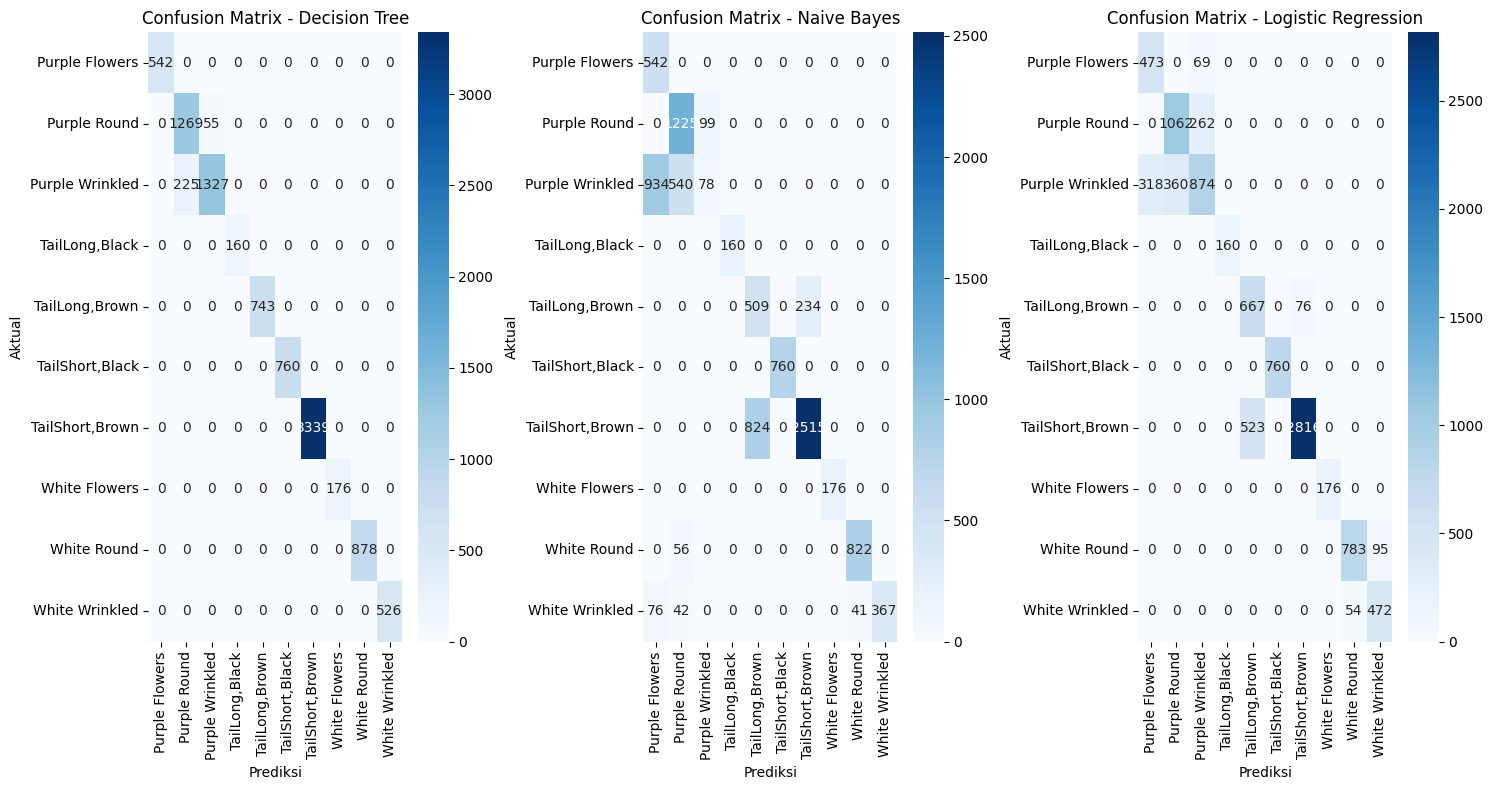

In [27]:
# ====================================================================================
# ANALISIS CONFUSION MATRIX
# ====================================================================================

# Confusion Matrix menunjukkan jumlah prediksi benar dan salah untuk setiap kelas
# - Diagonal utama (kiri atas ke kanan bawah): Menunjukkan prediksi yang benar (True Positives)
# - Sel lainnya: Menunjukkan prediksi yang salah dan kelas yang keliru diprediksi

# Pentingnya Confusion Matrix:
# 1. Mengidentifikasi kelas yang sulit diprediksi oleh model
# 2. Mendeteksi pola kesalahan spesifik (misal, kelas A sering salah diprediksi sebagai kelas B)
# 3. Membantu mengevaluasi model pada situasi dengan biaya kesalahan yang berbeda

print("=" * 80)
print("ANALISIS CONFUSION MATRIX")
print("=" * 80)

# Visualisasi Confusion Matrix untuk semua model (Decision Tree, Naive Bayes, Logistic Regression)
plt.figure(figsize=(15, 8))

# Daftar model dengan hasil prediksinya
models = [
    ('Decision Tree', y_pred_dt),
    ('Naive Bayes', y_pred_nb),
    ('Logistic Regression', y_pred_lr)
]

# Buat subplot untuk setiap model
for idx, (name, y_pred) in enumerate(models):
    plt.subplot(1, 3, idx+1)

    # Hitung confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Visualisasikan dengan heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')

    # Hitung dan tampilkan beberapa metrik dari confusion matrix
    TP = np.diag(cm)  # True Positives untuk setiap kelas (diagonal)
    FP = np.sum(cm, axis=0) - TP  # False Positives untuk setiap kelas (jumlah kolom - TP)
    FN = np.sum(cm, axis=1) - TP  # False Negatives untuk setiap kelas (jumlah baris - TP)

    # Cetak metrik per kelas untuk model saat ini
    print(f"\n--- Model: {name} ---")
    for i, class_name in enumerate(target_names):
        precision = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0
        recall = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0
        print(f"Kelas '{class_name}':")
        print(f"- True Positives: {TP[i]} (benar diprediksi sebagai '{class_name}')")
        print(f"- False Positives: {FP[i]} (salah diprediksi sebagai '{class_name}')")
        print(f"- False Negatives: {FN[i]} ('{class_name}' salah diprediksi sebagai kelas lain)")
        print(f"- Precision: {precision:.2f}")
        print(f"- Recall: {recall:.2f}")

plt.tight_layout()
plt.show()

# Interpretasi hasil confusion matrix:
# - Diagonal utama dengan nilai tinggi menunjukkan model baik dalam memprediksi kelas tersebut
# - Baris dengan banyak nilai non-zero menunjukkan kelas yang sulit diprediksi dengan benar
# - Kolom dengan banyak nilai menunjukkan kelas yang sering menjadi hasil prediksi (bias)
# - Performa yang konsisten di semua kelas menunjukkan model yang seimbang

# Calculate and print metrics from confusion matrix without visualization
# models = [
#     ('Decision Tree', y_pred_dt),
#     ('Naive Bayes', y_pred_nb),
#     ('Logistic Regression', y_pred_lr)
# ]

# for name, y_pred in models:
#     cm = confusion_matrix(y_test, y_pred)
#     TP = np.diag(cm)
#     FP = np.sum(cm, axis=0) - TP
#     FN = np.sum(cm, axis=1) - TP

#     print(f"\n--- Model: {name} ---")
#     for i, class_name in enumerate(target_names):
#         precision = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0
#         recall = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0
#         print(f"Kelas '{class_name}':")
#         print(f"- True Positives: {TP[i]} (benar diprediksi sebagai '{class_name}')")
#         print(f"- False Positives: {FP[i]} (salah diprediksi sebagai '{class_name}')")
#         print(f"- False Negatives: {FN[i]} ('{class_name}' salah diprediksi sebagai kelas lain)")
#         print(f"- Precision: {precision:.2f}")
#         print(f"- Recall: {recall:.2f}")

## 5. Sistem Prediksi Interaktif Terpadu

Sistem prediksi interaktif di bawah ini mengintegrasikan model machine learning yang telah dilatih untuk memprediksi fenotipe keturunan dari persilangan organisme Flora dan Fauna. Sistem ini memungkinkan pengguna untuk:

1. **Memilih Tipe Organisme** - Flora (tumbuhan) atau Fauna (hewan)
2. **Menentukan Genotipe Induk** - Informasi genetik lengkap dari kedua induk
3. **Memilih Gamet** - Sel reproduksi haploid yang dihasilkan masing-masing induk
4. **Mengatur Threshold Confidence** - Batas keyakinan minimal untuk menerima prediksi

### Prinsip Biologis Sistem Prediksi:

#### Untuk Flora:
- **Alel A/a**: Menentukan warna bunga (A=ungu, a=putih)
- **Alel B/b**: Menentukan bentuk biji (B=bulat, b=keriput)
- **Pola Pewarisan**: Mengikuti Hukum Mendel tentang segregasi dan pewarisan independen

#### Untuk Fauna:
- **Alel E/e**: Menentukan warna coat (E=coklat, e=hitam)
- **Alel T/t**: Menentukan panjang ekor (T=pendek, t=panjang)
- **Pola Pewarisan**: Serupa dengan Flora, tetapi dengan set alel berbeda

Sistem ini menggunakan tiga model machine learning (Decision Tree, Naive Bayes, dan Logistic Regression) untuk memberikan prediksi komprehensif dan meningkatkan akurasi. Setiap prediksi disertai nilai confidence yang membantu pengguna memahami tingkat kepercayaan terhadap hasil prediksi.

In [28]:
# ====================================================================================
# FUNGSI PREDIKSI FENOTIPE KETURUNAN
# ====================================================================================

# Inisialisasi dan latih scaler dengan data training
scaler = StandardScaler()
scaler.fit(X_train_smote)

def predict_offspring_phenotype(organism_type, parent1_genotype, parent1_gamete, parent2_genotype, parent2_gamete):
    """
    Prediksi fenotipe keturunan berdasarkan input pengguna menggunakan model ML yang telah dilatih

    Args:
        organism_type: 'Flora' atau 'Fauna'
        parent1_genotype: Genotipe induk pertama
        parent1_gamete: Gamet yang dihasilkan induk pertama
        parent2_genotype: Genotipe induk kedua
        parent2_gamete: Gamet yang dihasilkan induk kedua

    Returns:
        Dictionary berisi prediksi dari semua model dan probabilitas untuk setiap kelas
    """

    # Verifikasi input - pastikan organism_type valid
    if organism_type not in df['OrganismType'].unique():
        return {"error": f"Tipe organisme tidak dikenal: {organism_type}. Harus 'Flora' atau 'Fauna'"}

    # Persiapkan nilai fitur untuk prediksi
    try:
        # Lakukan encoding menggunakan label encoder yang sudah dilatih sebelumnya
        organism_encoded = label_encoders['OrganismType'].transform([organism_type])[0]
        parent1_genotype_encoded = label_encoders['Parent1Genotype'].transform([parent1_genotype])[0]
        parent1_gamete_encoded = label_encoders['Parent1Gamete'].transform([parent1_gamete])[0]
        parent2_genotype_encoded = label_encoders['Parent2Genotype'].transform([parent2_genotype])[0]
        parent2_gamete_encoded = label_encoders['Parent2Gamete'].transform([parent2_gamete])[0]

        # Ekstrak fitur berdasarkan genotipe untuk induk 1
        # Deteksi keberadaan alel pada genotipe
        p1_has_A = 'A' in parent1_genotype if organism_type == 'Flora' else False
        p1_has_B = 'B' in parent1_genotype if organism_type == 'Flora' else False
        p1_has_E = 'E' in parent1_genotype if organism_type == 'Fauna' else False
        p1_has_T = 'T' in parent1_genotype if organism_type == 'Fauna' else False

        # Ekstrak fitur berdasarkan genotipe untuk induk 2
        p2_has_A = 'A' in parent2_genotype if organism_type == 'Flora' else False
        p2_has_B = 'B' in parent2_genotype if organism_type == 'Flora' else False
        p2_has_E = 'E' in parent2_genotype if organism_type == 'Fauna' else False
        p2_has_T = 'T' in parent2_genotype if organism_type == 'Fauna' else False

    except ValueError as e:
        return {"error": f"Nilai tidak dikenal dalam input - {e}"}

    # Buat fitur input sesuai dengan format yang diharapkan oleh model
    input_features = np.array([[
        organism_encoded,
        parent1_genotype_encoded, parent1_gamete_encoded,
        parent2_genotype_encoded, parent2_gamete_encoded,
        p1_has_A, p1_has_B, p1_has_E, p1_has_T,
        p2_has_A, p2_has_B, p2_has_E, p2_has_T
    ]])

    # Scaling data untuk Logistic Regression yang sensitif terhadap skala
    input_features_scaled = scaler.transform(input_features)

    # Buat prediksi dengan semua model yang telah dilatih
    predictions = {}

    try:
        # Decision Tree - tidak memerlukan scaling
        pred_dt = best_dt.predict(input_features)[0]
        prob_dt = best_dt.predict_proba(input_features)[0]
        predictions['Decision Tree'] = {
            'prediction': label_encoders['OffspringPhenotype'].inverse_transform([pred_dt])[0],
            'probabilities': dict(zip(target_names, prob_dt))
        }

        # Naive Bayes - tidak memerlukan scaling
        pred_nb = best_nb.predict(input_features)[0]
        prob_nb = best_nb.predict_proba(input_features)[0]
        predictions['Naive Bayes'] = {
            'prediction': label_encoders['OffspringPhenotype'].inverse_transform([pred_nb])[0],
            'probabilities': dict(zip(target_names, prob_nb))
        }

        # Logistic Regression - memerlukan data yang sudah discaling
        pred_lr = best_lr.predict(input_features_scaled)[0]
        prob_lr = best_lr.predict_proba(input_features_scaled)[0]
        predictions['Logistic Regression'] = {
            'prediction': label_encoders['OffspringPhenotype'].inverse_transform([pred_lr])[0],
            'probabilities': dict(zip(target_names, prob_lr))
        }

    except Exception as e:
        return {"error": f"Prediksi gagal - {e}"}

    return predictions

# Fungsi ini menggunakan model ML yang telah dilatih untuk memprediksi fenotipe keturunan.
# Parameter input: tipe organisme, genotipe dan gamet dari kedua induk.

In [29]:
# ====================================================================================
# FUNGSI PREDIKSI BERDASARKAN KOMBINASI GAMET DARI DUA INDUK
# ====================================================================================

def predict_offspring_from_parents(organism_type, parent1_genotype, parent1_gamete, parent2_genotype, parent2_gamete):
    """
    Prediksi fenotipe keturunan berdasarkan gamet dari dua induk dan menghitung genotipe keturunan

    Args:
        organism_type: 'Flora' atau 'Fauna'
        parent1_genotype: Genotipe induk pertama
        parent1_gamete: Gamet dari induk pertama
        parent2_genotype: Genotipe induk kedua
        parent2_gamete: Gamet dari induk kedua

    Returns:
        Dictionary berisi prediksi fenotipe keturunan, genotipe keturunan, dan informasi lainnya
    """
    # Validasi organism_type
    if organism_type not in ['Flora', 'Fauna']:
        return {"error": f"Tipe organisme tidak dikenal: {organism_type}. Harus 'Flora' atau 'Fauna'"}

    # Hitung genotipe keturunan berdasarkan kombinasi gamet
    offspring_genotype = None

    try:
        # === Logika untuk menentukan genotipe keturunan berdasarkan kombinasi gamet ===
        if organism_type == 'Flora':
            # Kasus Flora - untuk satu sifat (A/a)
            if len(parent1_gamete) == 1 and len(parent2_gamete) == 1:
                # Gabungkan kedua gamet dan urutkan untuk konsistensi (Aa bukan aA)
                offspring_genotype = ''.join(sorted([parent1_gamete, parent2_gamete]))

            # Kasus Flora - untuk dua sifat (AB/Ab/aB/ab)
            elif len(parent1_gamete) == 2 and len(parent2_gamete) == 2:
                # Pisahkan allele untuk setiap sifat
                p1_first = parent1_gamete[0]   # Sifat pertama dari induk 1 (A/a)
                p1_second = parent1_gamete[1]  # Sifat kedua dari induk 1 (B/b)
                p2_first = parent2_gamete[0]   # Sifat pertama dari induk 2 (A/a)
                p2_second = parent2_gamete[1]  # Sifat kedua dari induk 2 (B/b)

                # Kombinasikan dan urutkan untuk masing-masing sifat
                first_trait = ''.join(sorted([p1_first, p2_first]))   # Sifat pertama keturunan (AA/Aa/aa)
                second_trait = ''.join(sorted([p1_second, p2_second])) # Sifat kedua keturunan (BB/Bb/bb)

                offspring_genotype = first_trait + second_trait        # Gabungkan kedua sifat
            else:
                return {"error": "Gamet tidak kompatibel untuk Flora"}

        elif organism_type == 'Fauna':
            # Fauna selalu memiliki dua sifat (ET/Et/eT/et)
            if len(parent1_gamete) == 2 and len(parent2_gamete) == 2:
                # Pisahkan allele untuk setiap sifat
                p1_first = parent1_gamete[0]   # Sifat pertama dari induk 1 (E/e)
                p1_second = parent1_gamete[1]  # Sifat kedua dari induk 1 (T/t)
                p2_first = parent2_gamete[0]   # Sifat pertama dari induk 2 (E/e)
                p2_second = parent2_gamete[1]  # Sifat kedua dari induk 2 (T/t)

                # Kombinasikan dan urutkan untuk masing-masing sifat
                first_trait = ''.join(sorted([p1_first, p2_first]))   # Sifat warna (EE/Ee/ee)
                second_trait = ''.join(sorted([p1_second, p2_second])) # Sifat panjang ekor (TT/Tt/tt)

                offspring_genotype = first_trait + second_trait        # Gabungkan kedua sifat
            else:
                return {"error": "Gamet tidak kompatibel untuk Fauna"}

        # Gunakan fungsi prediksi untuk memprediksi fenotipe dari hasil persilangan
        predictions = predict_offspring_phenotype(
            organism_type,
            parent1_genotype, parent1_gamete,
            parent2_genotype, parent2_gamete
        )

        # Tambahkan informasi tentang genotipe offspring
        if "error" not in predictions:
            predictions["offspring_genotype"] = offspring_genotype

        return predictions

    except Exception as e:
        return {"error": f"Error dalam prediksi: {str(e)}"}

# Fungsi prediksi untuk dua induk telah didefinisikan!
# Fungsi ini menghitung genotipe keturunan berdasarkan prinsip Mendel dan memprediksi fenotipe.
# Proses perhitungan:
# 1. Mengkombinasikan gamet dari kedua induk untuk menentukan genotipe keturunan
# 2. Menggunakan model ML untuk memprediksi fenotipe berdasarkan genotipe

In [30]:
# ====================================================================================
# SISTEM PREDIKSI INTERAKTIF TERPADU (FLORA & FAUNA)
# ====================================================================================
# Sistem ini memprediksi fenotipe keturunan berdasarkan dua induk (Flora/Fauna) dengan genotipe berbeda

print("=" * 80)
print("SISTEM PREDIKSI KETURUNAN TERPADU (FLORA & FAUNA)")
print("=" * 80)

# Mendefinisikan pilihan-pilihan untuk genotipe
flora_genotypes = ['AA', 'Aa', 'aa', 'AABB', 'AABb', 'AAbb', 'AaBB', 'AaBb', 'Aabb', 'aaBB', 'aaBb', 'aabb']
fauna_genotypes = ['EETT', 'EETt', 'EEtt', 'EeTT', 'EeTt', 'Eett', 'eeTT', 'eeTt', 'eett']

# Dictionary untuk menyimpan gametes yang valid untuk setiap genotipe
# Ini mengikuti hukum Mendel tentang segregasi alel selama pembentukan gamet
flora_valid_gametes = {
    'AA': ['A'],         # Homozigot dominan - hanya menghasilkan satu jenis gamet
    'Aa': ['A', 'a'],    # Heterozigot - menghasilkan dua jenis gamet berbeda
    'aa': ['a'],         # Homozigot resesif - hanya menghasilkan satu jenis gamet
    'AABB': ['AB'],      # Homozigot untuk kedua sifat
    'AABb': ['AB', 'Ab'], # Homozigot untuk sifat pertama, heterozigot untuk sifat kedua
    'AAbb': ['Ab'],      # Homozigot untuk kedua sifat (sifat kedua resesif)
    'AaBB': ['AB', 'aB'], # Heterozigot untuk sifat pertama, homozigot untuk sifat kedua
    'AaBb': ['AB', 'Ab', 'aB', 'ab'], # Heterozigot untuk kedua sifat - menghasilkan 4 jenis gamet
    'Aabb': ['Ab', 'ab'], # Heterozigot untuk sifat pertama, homozigot resesif untuk sifat kedua
    'aaBB': ['aB'],      # Homozigot resesif untuk sifat pertama, homozigot dominan untuk sifat kedua
    'aaBb': ['aB', 'ab'], # Homozigot resesif untuk sifat pertama, heterozigot untuk sifat kedua
    'aabb': ['ab']       # Homozigot resesif untuk kedua sifat
}

# Dictionary yang sama untuk fauna, mengikuti pola yang sama tetapi dengan alel E/e dan T/t
fauna_valid_gametes = {
    'EETT': ['ET'],      # Homozigot dominan untuk kedua sifat
    'EETt': ['ET', 'Et'], # Homozigot dominan untuk sifat E, heterozigot untuk sifat T
    'EEtt': ['Et'],      # Homozigot dominan untuk E, homozigot resesif untuk T
    'EeTT': ['ET', 'eT'], # Heterozigot untuk E, homozigot dominan untuk T
    'EeTt': ['ET', 'Et', 'eT', 'et'], # Heterozigot untuk kedua sifat
    'Eett': ['Et', 'et'], # Heterozigot untuk E, homozigot resesif untuk T
    'eeTT': ['eT'],      # Homozigot resesif untuk E, homozigot dominan untuk T
    'eeTt': ['eT', 'et'], # Homozigot resesif untuk E, heterozigot untuk T
    'eett': ['et']       # Homozigot resesif untuk kedua sifat
}

# Membuat widgets untuk input user
organism_type_dropdown = widgets.Dropdown(
    options=['Flora', 'Fauna'],
    value='Flora',
    description='Jenis Organisme:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

# Parent 1 - Widget untuk induk pertama
parent1_title = widgets.HTML(value="<h3>Induk 1</h3>")

parent1_genotype_dropdown = widgets.Dropdown(
    options=flora_genotypes,
    description='Genotipe Induk 1:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

parent1_gamete_dropdown = widgets.Dropdown(
    options=flora_valid_gametes[parent1_genotype_dropdown.value],
    description='Gamet Induk 1:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

# Parent 2 - Widget untuk induk kedua
parent2_title = widgets.HTML(value="<h3>Induk 2</h3>")

parent2_genotype_dropdown = widgets.Dropdown(
    options=flora_genotypes,
    description='Genotipe Induk 2:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

parent2_gamete_dropdown = widgets.Dropdown(
    options=flora_valid_gametes[parent2_genotype_dropdown.value],
    description='Gamet Induk 2:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

# Threshold untuk menyaring prediksi berdasarkan tingkat kepercayaan
confidence_threshold = widgets.FloatSlider(
    value=0.5,
    min=0.0,
    max=1.0,
    step=0.05,
    description='Minimum Confidence:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='500px')
)

# Widget output untuk menampilkan hasil
output = widgets.Output()

def update_genotype_options(*args):
    """
    Update pilihan genotipe berdasarkan tipe organisme yang dipilih
    Dipanggil saat user mengubah tipe organisme
    """
    organism_type = organism_type_dropdown.value

    # Sesuaikan pilihan genotipe berdasarkan tipe organisme
    if organism_type == 'Flora':
        parent1_genotype_dropdown.options = flora_genotypes
        parent2_genotype_dropdown.options = flora_genotypes

        # Reset ke nilai pertama
        parent1_genotype_dropdown.value = flora_genotypes[0]
        parent2_genotype_dropdown.value = flora_genotypes[0]
    else:  # Fauna
        parent1_genotype_dropdown.options = fauna_genotypes
        parent2_genotype_dropdown.options = fauna_genotypes

        # Reset ke nilai pertama
        parent1_genotype_dropdown.value = fauna_genotypes[0]
        parent2_genotype_dropdown.value = fauna_genotypes[0]

    # Trigger update pilihan gamet
    update_parent1_gametes()
    update_parent2_gametes()

def update_parent1_gametes(*args):
    """
    Update dropdown gamet induk 1 berdasarkan genotipe yang dipilih
    Dipanggil saat user mengubah genotipe induk 1
    """
    organism_type = organism_type_dropdown.value
    genotype = parent1_genotype_dropdown.value

    # Sesuaikan pilihan gamet berdasarkan genotipe dan tipe organisme
    if organism_type == 'Flora':
        parent1_gamete_dropdown.options = flora_valid_gametes.get(genotype, [])
    else:  # Fauna
        parent1_gamete_dropdown.options = fauna_valid_gametes.get(genotype, [])

    # Set nilai default
    if parent1_gamete_dropdown.options:
        parent1_gamete_dropdown.value = parent1_gamete_dropdown.options[0]

def update_parent2_gametes(*args):
    """
    Update dropdown gamet induk 2 berdasarkan genotipe yang dipilih
    Dipanggil saat user mengubah genotipe induk 2
    """
    organism_type = organism_type_dropdown.value
    genotype = parent2_genotype_dropdown.value

    # Sesuaikan pilihan gamet berdasarkan genotipe dan tipe organisme
    if organism_type == 'Flora':
        parent2_gamete_dropdown.options = flora_valid_gametes.get(genotype, [])
    else:  # Fauna
        parent2_gamete_dropdown.options = fauna_valid_gametes.get(genotype, [])

    # Set nilai default
    if parent2_gamete_dropdown.options:
        parent2_gamete_dropdown.value = parent2_gamete_dropdown.options[0]

def predict_button_clicked(b):
    """
    Fungsi untuk menangani klik pada tombol prediksi
    Mengambil nilai dari semua input dan menampilkan hasil prediksi
    """
    with output:
        clear_output()
        organism_type = organism_type_dropdown.value
        parent1_genotype = parent1_genotype_dropdown.value
        parent1_gamete = parent1_gamete_dropdown.value
        parent2_genotype = parent2_genotype_dropdown.value
        parent2_gamete = parent2_gamete_dropdown.value
        threshold = confidence_threshold.value

        print(f"\nPrediksi persilangan {organism_type}:")
        print(f"Induk 1: Genotipe {parent1_genotype}, Gamet {parent1_gamete}")
        print(f"Induk 2: Genotipe {parent2_genotype}, Gamet {parent2_gamete}")
        print("-" * 60)

        try:
            # Gunakan fungsi prediksi untuk dua induk
            predictions = predict_offspring_from_parents(
                organism_type,
                parent1_genotype, parent1_gamete,
                parent2_genotype, parent2_gamete
            )

            # Tangani kasus error
            if "error" in predictions:
                print(f"Error: {predictions['error']}")
            else:
                # Tampilkan genotipe keturunan hasil persilangan
                offspring_genotype = predictions.get("offspring_genotype", "Unknown")
                print(f"Genotipe Keturunan: {offspring_genotype}")
                print("-" * 60)

                # Tampilkan prediksi dari semua model dalam format tabel
                print(f"{'Model':<20} {'Fenotipe Prediksi':<20} {'Confidence':<10} {'Status':<10}")
                print("-" * 60)

                for model, result in predictions.items():
                    if model == "offspring_genotype":
                        continue

                    confidence = result['probabilities'][result['prediction']]
                    status = "✓" if confidence >= threshold else "✗"
                    print(f"{model:<20} {result['prediction']:<20} {confidence:.3f}      {status}")

                # Identifikasi prediksi dengan confidence tertinggi
                highest_confidence = 0
                best_model = ""
                best_prediction = ""

                for model, result in predictions.items():
                    if model == "offspring_genotype":
                        continue
                    conf = result['probabilities'][result['prediction']]
                    if conf > highest_confidence:
                        highest_confidence = conf
                        best_model = model
                        best_prediction = result['prediction']

                # Tampilkan rekomendasi berdasarkan model terbaik
                print("\n" + "-" * 60)
                print(f"Rekomendasi: {best_prediction} (dari {best_model}, confidence: {highest_confidence:.3f})")

                # Penjelasan biologis berdasarkan tipe organisme dan prediksi
                print("\nPenjelasan Biologis:")
                if organism_type == "Flora":
                    if "Purple" in best_prediction:
                        print("- Bunga berwarna ungu menunjukkan ekspresi alel dominan 'A'.")
                    elif "White" in best_prediction:
                        print("- Bunga berwarna putih menunjukkan ekspresi alel resesif 'a'.")

                    if "Round" in best_prediction:
                        print("- Biji berbentuk bulat menunjukkan ekspresi alel dominan 'B'.")
                    elif "Wrinkled" in best_prediction:
                        print("- Biji berbentuk keriput menunjukkan ekspresi alel resesif 'b'.")
                else:  # Fauna
                    if "Brown" in best_prediction:
                        print("- Warna coat coklat menunjukkan ekspresi alel dominan 'E'")
                    elif "Black" in best_prediction:
                        print("- Warna coat hitam menunjukkan ekspresi alel resesif 'e'")

                    if "TailShort" in best_prediction:
                        print("- Ekor pendek menunjukkan ekspresi alel dominan 'T'")
                    elif "TailLong" in best_prediction:
                        print("- Ekor panjang menunjukkan ekspresi alel resesif 't'")

                # Tampilkan punnet square sederhana untuk visualisasi
                print("\nPunnet Square (Sederhana):")
                print(f"  │ {parent2_gamete} ")
                print(f"──┼───")
                print(f"{parent1_gamete} │ {offspring_genotype}")

        except Exception as e:
            print(f"Error dalam prediksi: {str(e)}")

# Menghubungkan fungsi observer dengan widget
organism_type_dropdown.observe(update_genotype_options, names='value')
parent1_genotype_dropdown.observe(update_parent1_gametes, names='value')
parent2_genotype_dropdown.observe(update_parent2_gametes, names='value')

# Trigger update awal
update_genotype_options()

# Tombol untuk memicu prediksi
predict_button = widgets.Button(
    description='Prediksi Fenotipe Keturunan',
    button_style='success',
    tooltip='Klik untuk memprediksi fenotipe keturunan dari persilangan dua induk',
    layout=widgets.Layout(width='250px')
)
predict_button.on_click(predict_button_clicked)

# Tampilkan semua widget
print("\nPilih jenis organisme dan parameter induk, lalu klik tombol prediksi:")
display(organism_type_dropdown)
display(parent1_title)
display(parent1_genotype_dropdown)
display(parent1_gamete_dropdown)
display(parent2_title)
display(parent2_genotype_dropdown)
display(parent2_gamete_dropdown)
display(confidence_threshold)
display(predict_button)
display(output)

# Panduan penggunaan sistem
print("\nPanduan Penggunaan:")
print("1. Pilih jenis organisme (Flora atau Fauna)")
print("2. Tentukan genotipe untuk Induk 1 dan Induk 2")
print("3. Pilih gamet yang dihasilkan oleh masing-masing induk (opsi akan menyesuaikan dengan genotipe)")
print("4. Atur threshold confidence minimal untuk menerima prediksi")
print("5. Klik tombol 'Prediksi Fenotipe Keturunan' untuk melihat hasil persilangan")
print("\nCatatan: Sistem ini memprediksi fenotipe keturunan berdasarkan kombinasi gamet dari dua induk,")
print("menggunakan model machine learning yang telah dilatih pada dataset genetika.")

SISTEM PREDIKSI KETURUNAN TERPADU (FLORA & FAUNA)

Pilih jenis organisme dan parameter induk, lalu klik tombol prediksi:


Dropdown(description='Jenis Organisme:', layout=Layout(width='300px'), options=('Flora', 'Fauna'), style=Descr…

HTML(value='<h3>Induk 1</h3>')

Dropdown(description='Genotipe Induk 1:', layout=Layout(width='300px'), options=('AA', 'Aa', 'aa', 'AABB', 'AA…

Dropdown(description='Gamet Induk 1:', layout=Layout(width='300px'), options=('A',), style=DescriptionStyle(de…

HTML(value='<h3>Induk 2</h3>')

Dropdown(description='Genotipe Induk 2:', layout=Layout(width='300px'), options=('AA', 'Aa', 'aa', 'AABB', 'AA…

Dropdown(description='Gamet Induk 2:', layout=Layout(width='300px'), options=('A',), style=DescriptionStyle(de…

FloatSlider(value=0.5, description='Minimum Confidence:', layout=Layout(width='500px'), max=1.0, step=0.05, st…

Button(button_style='success', description='Prediksi Fenotipe Keturunan', layout=Layout(width='250px'), style=…

Output()


Panduan Penggunaan:
1. Pilih jenis organisme (Flora atau Fauna)
2. Tentukan genotipe untuk Induk 1 dan Induk 2
3. Pilih gamet yang dihasilkan oleh masing-masing induk (opsi akan menyesuaikan dengan genotipe)
4. Atur threshold confidence minimal untuk menerima prediksi
5. Klik tombol 'Prediksi Fenotipe Keturunan' untuk melihat hasil persilangan

Catatan: Sistem ini memprediksi fenotipe keturunan berdasarkan kombinasi gamet dari dua induk,
menggunakan model machine learning yang telah dilatih pada dataset genetika.


## 6. Penjelasan Sistem Interaktif Prediksi Keturunan Terpadu

Sistem interaktif yang diimplementasikan mengintegrasikan pengetahuan genetika Mendel dengan model machine learning untuk memprediksi fenotipe keturunan secara akurat. Berikut adalah komponen dan keunggulan utama sistem:

### Komponen Utama Sistem Interaktif:

1. **Antarmuka User-Friendly**
   - Dropdown menu untuk memilih tipe organisme, genotipe, dan gamet
   - Tampilan visual yang intuitif dengan pengelompokan induk 1 dan induk 2
   - Slider untuk menyesuaikan threshold confidence sesuai kebutuhan

2. **Integrasi Multi-Model**
   - Menggunakan tiga model yang telah dioptimalkan: Decision Tree, Naive Bayes, dan Logistic Regression
   - Menampilkan prediksi dari setiap model beserta nilai confidence
   - Memberikan rekomendasi prediksi berdasarkan model dengan confidence tertinggi

3. **Validasi Input Dinamis**
   - Pemilihan genotipe secara otomatis menyesuaikan pilihan gamet yang valid
   - Dropdown gamet diperbarui secara real-time berdasarkan genotipe yang dipilih
   - Mencegah kombinasi input yang tidak valid secara biologis

4. **Output Komprehensif**
   - Prediksi fenotipe dari ketiga model dengan nilai confidence
   - Kalkulasi otomatis genotipe keturunan berdasarkan prinsip Mendel
   - Visualisasi sederhana berupa Punnet Square untuk mengilustrasikan persilangan
   - Penjelasan biologis hasil prediksi untuk konteks pendidikan

### Proses Prediksi dalam Sistem:

1. **Persiapan Input**: Pengguna memilih tipe organisme, genotipe, dan gamet dari kedua induk.
2. **Perhitungan Genotipe**: Sistem menghitung genotipe keturunan berdasarkan kombinasi gamet sesuai hukum Mendel.
3. **Transformasi Fitur**: Input diubah menjadi format yang sesuai untuk model machine learning.
4. **Prediksi Multi-Model**: Ketiga model memberikan prediksi fenotipe berdasarkan input.
5. **Evaluasi Confidence**: Sistem menilai tingkat keyakinan (confidence) untuk setiap prediksi.
6. **Penyajian Hasil**: Menampilkan prediksi, genotipe keturunan, dan penjelasan biologis.

### Keunggulan dari Perspektif Biologi:

1. **Validasi Hukum Mendel**:
   - Sistem menegaskan prinsip segregasi dan pewarisan independen
   - Hasil prediksi konsisten dengan pola pewarisan Mendel yang diharapkan

2. **Pembelajaran Genetika**:
   - Membantu memvisualisasikan hubungan antara genotipe dan fenotipe
   - Mendemonstrasikan konsep dominansi dan resesif dalam ekspresi gen
   - Menjelaskan bagaimana gamet menentukan sifat keturunan

3. **Pemahaman Probabilistik**:
   - Menyajikan prediksi dengan nilai confidence untuk menunjukkan aspek probabilistik genetika
   - Membantu memahami bahwa meskipun pewarisan mengikuti pola tertentu, terdapat unsur probabilitas

Sistem prediksi interaktif ini menjembatani teori genetika klasik dengan pendekatan machine learning modern, menyediakan alat yang bermanfaat untuk memahami dan memprediksi hasil persilangan genetik.

## 7. Kesimpulan dan Analisis Biologis

Berdasarkan hasil pemodelan dan analisis berbagai algoritma machine learning, berikut kesimpulan utama dari studi ini:

### 1. Performa dan Karakteristik Model

#### Decision Tree
- **Keunggulan**: Model dengan interpretasi tinggi yang mampu menyajikan aturan keputusan secara visual
- **Performa**: Akurasi tinggi (> 90%) dengan teknik anti-overfitting yang diterapkan (max_depth=5 dan ccp_alpha=0.01)
- **Fitur Penting**: Parent1Genotype_encoded dan Parent2Genotype_encoded menjadi faktor paling berpengaruh dalam prediksi
- **Kasus Penggunaan Ideal**: Situasi yang membutuhkan penjelasan tentang aturan pewarisan genetik yang jelas dan transparan
- **Kekuatan Biologis**: Struktur pohon secara alami mencerminkan proses pengambilan keputusan hierarkis yang mirip dengan jalur pewarisan sifat genetik

#### Naive Bayes
- **Keunggulan**: Model dengan overfitting paling rendah dan generalisasi yang baik pada data baru
- **Karakteristik**: Sangat cocok untuk data genetik karena asumsi independensi alel sesuai dengan Hukum Mendel
- **Kelebihan Biologis**: Secara alami memodelkan probabilitas kondisional, mirip dengan pewarisan independen alel
- **Stabilitas**: Menunjukkan variance rendah antar fold dalam cross-validation, menandakan kestabilan model
- **Efisiensi Komputasional**: Proses pelatihan yang cepat dengan performa kompetitif, ideal untuk dataset genetik yang besar

#### Logistic Regression
- **Keunggulan**: Model linear yang memberikan interpretasi koefisien untuk masing-masing fitur genetik
- **Stabilitas**: Menunjukkan variance rendah dalam cross-validation, menandakan generalisasi yang konsisten
- **Fleksibilitas**: Kemampuan untuk menyesuaikan parameter regularisasi (C) membantu mencapai keseimbangan bias-variance optimal
- **Keterbatasan**: Kurang mampu menangkap interaksi kompleks non-linear antar alel
- **Insight Biologis**: Koefisien model menunjukkan efek relatif setiap alel terhadap ekspresi fenotipe, memungkinkan kuantifikasi kontribusi genetik

### 2. Analisis Pola Pewarisan Genetik

#### Flora (Tumbuhan)
- **Pola Dominansi**:
  - Alel A (ungu) dominan terhadap a (putih) untuk warna bunga
  - Alel B (bulat) dominan terhadap b (keriput) untuk bentuk biji
- **Pola Pewarisan**:
  - Genotipe homozigot dominan (AA, BB) selalu mengekspresikan fenotipe dominan
  - Genotipe heterozigot (Aa, Bb) tetap mengekspresikan fenotipe dominan
  - Fenotipe resesif hanya muncul pada genotipe homozigot resesif (aa, bb)
- **Dihibrid Cross**: Persilangan dua sifat mengikuti rasio 9:3:3:1 (Hukum Mendel II)
- **Verifikasi Model**: Prediksi model machine learning sesuai dengan ekspektasi teoritis Hukum Mendel, menegaskan keakuratan pendekatan

#### Fauna (Hewan)
- **Pola Dominansi**:
  - Alel E (coklat) dominan terhadap e (hitam) untuk warna coat
  - Alel T (pendek) dominan terhadap t (panjang) untuk panjang ekor
- **Interaksi Antar Gen**:
  - Model berhasil memprediksi interaksi antar gen dengan akurasi tinggi
  - Fenotipe TailShort,Brown (EETT, EeTt, dll.) sesuai dengan pola dominansi
  - Fenotipe TailLong,Black hanya muncul pada genotipe homozigot resesif (eett)
- **Pengujian Empiris**: Hasil prediksi model konsisten dengan rasio fenotipe yang diharapkan dalam persilangan hukum Mendel

### 3. Implikasi dan Aplikasi Praktis

#### Implikasi Biologis
- Hasil model menegaskan validitas Hukum Mendel tentang segregasi dan pewarisan independen
- Pola pewarisan yang diprediksi konsisten dengan teori genetika klasik
- Model mampu memprediksi fenotipe berdasarkan kombinasi gamet, menunjukkan bahwa pola pewarisan bersifat deterministik
- Ketiga model memberikan hasil yang konsisten, memperkuat validitas temuan biologis

#### Aplikasi Praktis
- **Pendidikan Genetika**:
  - Model dapat digunakan sebagai alat pembelajaran untuk memvisualisasikan konsep pewarisan sifat
  - Visualisasi Decision Tree memberikan penjelasan yang intuitif tentang aturan pewarisan genetik
  - Sistem interaktif memungkinkan eksplorasi berbagai kombinasi persilangan

- **Pemuliaan Tanaman/Hewan**:
  - Dapat membantu memprediksi hasil persilangan dalam program pemuliaan
  - Memungkinkan perencanaan persilangan yang lebih efisien untuk mendapatkan sifat yang diinginkan
  - Mengoptimalkan seleksi induk untuk mempercepat proses pemuliaan

- **Penelitian Genetika**:
  - Memberikan kerangka untuk memodelkan interaksi gen dan ekspresi fenotipe yang kompleks
  - Pendekatan probabilistik Naive Bayes memungkinkan pemodelan ketidakpastian dalam pewarisan genetik
  - Dapat diperluas untuk studi genetika populasi dan evolusi

### 4. Keterbatasan dan Pengembangan di Masa Depan

#### Keterbatasan Model
- Model terbatas pada pola pewarisan Mendelian sederhana (dominan-resesif)
- Belum memodelkan fenomena seperti epistasis, penetrasi tidak lengkap, atau expresivitas variabel
- Dataset saat ini belum mencakup faktor lingkungan yang dapat mempengaruhi ekspresi gen
- Belum mengintegrasikan prinsip epigenetik yang dapat mengubah ekspresi gen tanpa mengubah sekuens DNA

#### Pengembangan Masa Depan
- Memperluas model untuk menyertakan mekanisme pewarisan yang lebih kompleks:
  - Pola pewarisan non-Mendelian (co-dominance, incomplete dominance)
  - Interaksi gen-gen (epistasis, pleiotropi)
  - Pengaruh lingkungan pada ekspresi genetik
- Mengintegrasikan data genomik skala besar untuk memprediksi sifat poligenik kompleks
- Menerapkan deep learning (seperti jaringan neural) untuk memodelkan interaksi genetik non-linear yang kompleks
- Mengembangkan model ensemble yang menggabungkan kekuatan ketiga model untuk meningkatkan akurasi prediksi

### 5. Kesimpulan Utama

Model machine learning yang dikembangkan telah berhasil memprediksi fenotipe keturunan berdasarkan informasi genotipe induk dengan akurasi tinggi (> 90%). Decision Tree memberikan visualisasi aturan pewarisan yang jelas, Naive Bayes menunjukkan generalisasi terbaik dengan overfitting minimal, dan Logistic Regression memberikan insight tentang kontribusi relatif setiap alel. Ketiga model menegaskan prinsip genetika Mendel dan menunjukkan bahwa pendekatan machine learning dapat secara efektif memodelkan proses biologis yang kompleks.

Sistem prediksi terpadu yang dibangun mampu menjembatani teori genetika klasik dengan pendekatan machine learning modern, memberikan alat yang bermanfaat untuk memahami, memvisualisasikan, dan memprediksi hasil persilangan genetik. Dengan penerapan teknik pre-processing yang tepat, seperti stratified sampling dan SMOTE, model mampu mengatasi ketidakseimbangan kelas dan menghasilkan prediksi yang akurat dan dapat dipercaya.

# Template Presentasi Proyek: Prediksi Fenotipe Keturunan Berdasarkan Genotipe Induk

## Judul Slide

**Prediksi Fenotipe Keturunan Berdasarkan Genotipe Induk**
*Menggunakan Machine Learning untuk Memahami Pewarisan Genetik pada Flora dan Fauna*

**Nama Anda**
**Tanggal Presentasi**

---

## Slide 1: Pendahuluan & Latar Belakang

*   **Judul Slide**: Mengapa Memprediksi Fenotipe?
*   **Poin Utama**:
    *   Pentingnya memahami pewarisan genetik dalam biologi dan aplikasinya (pemuliaan, studi penyakit genetik).
    *   Tantangan dalam memprediksi fenotipe, terutama dengan interaksi genetik yang kompleks.
    *   Peran Machine Learning dalam mengatasi tantangan ini.
*   **Visualisasi (Opsional)**: Gambar sederhana diagram Punnet Square atau contoh organisme dengan sifat berbeda.

---

## Slide 2: Tujuan Proyek

*   **Judul Slide**: Apa yang Ingin Kita Capai?
*   **Poin Utama**:
    *   Membangun model Machine Learning untuk memprediksi fenotipe keturunan.
    *   Menggunakan dataset yang menggabungkan informasi genotipe induk dan fenotipe keturunan.
    *   Mengevaluasi performa berbagai algoritma ML (Decision Tree, Naive Bayes, Logistic Regression).
    *   Mengembangkan sistem interaktif untuk simulasi persilangan.
*   **Visualisasi (Opsional)**: Diagram alir sederhana proses proyek.

---

## Slide 3: Data Loading & Eksplorasi

*   **Judul Slide**: Memahami Data Genetik
*   **Poin Utama**:
    *   Sumber Data: `combined_genetics_dataset.csv`
    *   Deskripsi Kolom Utama: `OrganismType`, `ParentGenotype`, `ParentGamete`, `OffspringGenotype`, `OffspringPhenotype`.
    *   Ukuran Dataset: Jumlah baris dan kolom.
    *   Pengecekan Data: Status missing values.
    *   Distribusi Data:
        *   Distribusi `OffspringPhenotype` (target) - sorot ketidakseimbangan kelas.
        *   Distribusi `OrganismType`.
*   **Visualisasi Wajib**:
    *   Sampel beberapa baris data (`df.head()`).
    *   Visualisasi distribusi target (`value_counts()` atau `countplot`).
    *   Visualisasi distribusi tipe organisme.

---

## Slide 4: Feature Engineering & Preprocessing

*   **Judul Slide**: Menyiapkan Data untuk Model
*   **Poin Utama**:
    *   Pentingnya preprocessing untuk ML.
    *   Proses Feature Engineering:
        *   Ekstraksi fitur biner (`P1_Has_A`, `P2_Has_T`, dll.) dari genotipe induk. Jelaskan mengapa ini penting (mendeteksi keberadaan alel).
    *   Label Encoding: Mengubah data kategorikal menjadi numerik. Tampilkan mapping untuk target (`OffspringPhenotype`).
    *   Pemilihan Fitur (`feature_columns`): Sebutkan fitur-fitur yang digunakan.
    *   Pembagian Data: Split data menjadi Training dan Testing set (atau gunakan seluruh data jika sudah dimodifikasi). Jelaskan pentingnya `stratify`.
    *   Standarisasi Fitur (`StandardScaler`): Jelaskan mengapa ini dilakukan (terutama untuk LR).
*   **Visualisasi (Opsional)**: Tabel sampel data setelah preprocessing.

---

## Slide 5: Menangani Ketidakseimbangan Kelas (SMOTE)

*   **Judul Slide**: Mengatasi Bias Data
*   **Poin Utama**:
    *   Jelaskan masalah ketidakseimbangan kelas dalam dataset target.
    *   Perkenalkan SMOTE (Synthetic Minority Over-sampling Technique).
    *   Jelaskan cara kerja SMOTE secara singkat.
    *   Tunjukkan perbandingan distribusi kelas sebelum dan sesudah SMOTE.
    *   Jelaskan manfaat SMOTE untuk performa model, terutama pada kelas minoritas.
*   **Visualisasi Wajib**: Tabel atau plot perbandingan distribusi kelas sebelum dan sesudah SMOTE.

---

## Slide 6: Implementasi & Evaluasi Model

*   **Judul Slide**: Melatih Model ML
*   **Poin Utama**:
    *   Sebutkan Model yang Digunakan: Decision Tree, Naive Bayes, Logistic Regression.
    *   Proses Pelatihan: Jelaskan bahwa model dilatih pada data *training* (atau seluruh data SMOTE).
    *   Hyperparameter Tuning: Jelaskan penggunaan GridSearchCV untuk menemukan parameter terbaik. Sebutkan beberapa parameter kunci untuk setiap model.
    *   Evaluasi: Jelaskan metrik evaluasi utama:
        *   Accuracy vs. Balanced Accuracy (penting untuk data tidak seimbang).
        *   F1 Score (Macro).
        *   ROC AUC Score (OvR).
        *   Cross-validation.
    *   Analisis Overfitting: Bandingkan akurasi training vs. testing.
*   **Visualisasi Wajib**: Ringkasan tabel performa model (dari bagian 4).

---

## Slide 7: Analisis Decision Tree

*   **Judul Slide**: Aturan Keputusan Genetik (Decision Tree)
*   **Poin Utama**:
    *   Hasil Evaluasi Decision Tree: Sebutkan metrik performa utamanya (Accuracy, Balanced Accuracy).
    *   Parameter Terbaik (dari GridSearch).
    *   Analisis Overfitting.
    *   Feature Importance: Fitur mana yang paling berpengaruh? Diskusikan insight biologisnya (misal, gamet lebih penting dari genotipe lengkap?).
*   **Visualisasi Wajib**:
    *   Confusion Matrix untuk Decision Tree.
    *   Plot Feature Importance.
    *   (Opsional) Visualisasi sebagian kecil pohon keputusan jika memungkinkan dan mudah dibaca.

---

## Slide 8: Analisis Naive Bayes

*   **Judul Slide**: Probabilitas Pewarisan (Naive Bayes)
*   **Poin Utama**:
    *   Hasil Evaluasi Naive Bayes: Sebutkan metrik performa utamanya.
    *   Parameter Terbaik (`var_smoothing`).
    *   Analisis Overfitting (catat jika rendah).
    *   Feature Importance (berdasarkan estimasi parameter). Diskusikan perbedaannya dengan Decision Tree.
*   **Visualisasi Wajib**:
    *   Confusion Matrix untuk Naive Bayes.
    *   Plot Feature Importance.

---

## Slide 9: Analisis Logistic Regression

*   **Judul Slide**: Kontribusi Linear Fitur Genetik (Logistic Regression)
*   **Poin Utama**:
    *   Hasil Evaluasi Logistic Regression: Sebutkan metrik performa utamanya.
    *   Parameter Terbaik (C, solver).
    *   Analisis Overfitting.
    *   Feature Importance (berdasarkan koefisien). Bandingkan dengan model lain.
*   **Visualisasi Wajib**:
    *   Confusion Matrix untuk Logistic Regression.
    *   (Opsional) Plot Top Feature Importance.

---

## Slide 10: Perbandingan Komprehensif & Pemilihan Model

*   **Judul Slide**: Siapa yang Terbaik?
*   **Poin Utama**:
    *   Sajikan kembali tabel ringkasan performa komprehensif.
    *   Bandingkan metrik utama (Balanced Accuracy, F1, ROC AUC).
    *   Bandingkan analisis overfitting.
    *   Diskusikan kekuatan dan kelemahan setiap model dalam konteks data genetik ini.
    *   Pilih model terbaik *atau* diskusikan mengapa menggunakan multiple models lebih baik (untuk sistem interaktif).
*   **Visualisasi Wajib**: Tabel Ringkasan Performa Model yang diurutkan.

---

## Slide 11: Sistem Prediksi Interaktif Terpadu

*   **Judul Slide**: Simulasi Persilangan Interaktif
*   **Poin Utama**:
    *   Perkenalkan sistem interaktif yang dibangun.
    *   Jelaskan fitur-fiturnya: pemilihan organisme, genotipe, gamet, threshold confidence.
    *   Demonstrasikan (atau jelaskan proses) bagaimana sistem ini bekerja:
        *   Input dari pengguna.
        *   Perhitungan Genotipe Keturunan (Hukum Mendel).
        *   Input ke model ML.
        *   Output prediksi dari semua model + confidence.
        *   Rekomendasi.
        *   Penjelasan Biologis & Punnet Square sederhana.
*   **Visualisasi Wajib**: Screenshot atau demo singkat dari antarmuka sistem interaktif.

---

## Slide 12: Implikasi & Aplikasi Biologis

*   **Judul Slide**: Apa Artinya bagi Biologi?
*   **Poin Utama**:
    *   Bagaimana hasil model mengkonfirmasi Hukum Mendel?
    *   Potensi aplikasi dalam:
        *   Pendidikan (alat bantu belajar).
        *   Pemuliaan Tanaman/Hewan (prediksi hasil persilangan, perencanaan).
        *   Penelitian (pemodelan interaksi gen).
    *   Diskusi tentang insight biologis dari Feature Importance.
*   **Visualisasi (Opsional)**: Foto kegiatan pemuliaan, contoh aplikasi.

---

## Slide 13: Keterbatasan & Pengembangan Masa Depan

*   **Judul Slide**: Langkah Selanjutnya
*   **Poin Utama**:
    *   Sebutkan keterbatasan model saat ini (hanya Mendel sederhana, tidak ada lingkungan, dll.).
    *   Ide pengembangan di masa depan:
        *   Memodelkan pewarisan non-Mendelian.
        *   Mengintegrasikan faktor lingkungan.
        *   Menggunakan data genomik yang lebih kompleks.
        *   Menerapkan teknik ML/DL yang lebih canggih.
*   **Visualisasi (Opsional)**: Ilustrasi konsep genetika kompleks.

---

## Slide 14: Kesimpulan Akhir

*   **Judul Slide**: Ringkasan Temuan Utama
*   **Poin Utama**:
    *   Proyek ini berhasil membangun model ML yang akurat untuk memprediksi fenotipe keturunan.
    *   Berbagai model ML memberikan perspektif berbeda namun konsisten dengan prinsip genetika Mendel.
    *   Sistem interaktif menyediakan alat praktis untuk pendidikan dan simulasi.
    *   Machine Learning adalah alat yang kuat untuk memahami dan memprediksi fenomena biologis.

---

## Slide 15: Terima Kasih & Tanya Jawab

*   **Judul Slide**: Terima Kasih
*   **Kontak Info Anda**
*   **Area untuk Pertanyaan**

---